# üõí Sistema de Recomendaci√≥n para E-Commerce
**Autor:** David Caleb Chaparro Orozco  
**Fecha:** Octubre 2025

---

## üìã Contenido

1. [Introducci√≥n y Objetivos](#seccion-1-introduccion)
2. [Metodolog√≠a CRISP-DM](#seccion-2-metodologia)
3. [An√°lisis Exploratorio de Datos (EDA)](#seccion-3-eda)
4. [Preprocesamiento y Preparaci√≥n](#seccion-4-preprocesamiento)
5. [Sistema de Recomendaci√≥n](#seccion-5-sistema-recomendacion)
6. [Evaluaci√≥n de Modelos](#seccion-6-evaluacion)
7. [Sistema de Actualizaci√≥n](#seccion-7-actualizacion)
8. [Monitorizaci√≥n Continua](#seccion-8-monitorizacion)
9. [Framework de A/B Testing](#seccion-9-ab-testing)
10. [Conclusiones y Recomendaciones](#seccion-10-conclusiones)

---

<a id="seccion-1-introduccion"></a>
## üéØ 1. Introducci√≥n y Objetivos

### Contexto del Proyecto
Este proyecto busca crear un sistema de recomendaci√≥n efectivo para una plataforma de e-commerce, con el objetivo de mejorar la experiencia de compra y aumentar las ventas mediante sugerencias personalizadas.

### Objetivos Principales

**A nivel t√©cnico:**
- Implementar diferentes algoritmos de recomendaci√≥n
- Alcanzar una Precision@10 mayor a 0.003
- Resolver el problema de cold start
- Trabajar con datos dispersos (sparse data)

**A nivel de negocio:**
- Mejorar el CTR en recomendaciones (meta: +15%)
- Aumentar la tasa de conversi√≥n (+10%)
- Incrementar la retenci√≥n de clientes

### Alcance del Proyecto

**Incluye:** EDA completo, 5 algoritmos diferentes, evaluaci√≥n offline, estrategia de deployment

**No incluye:** Deep Learning avanzado, procesamiento en tiempo real, NLP

---


In [1]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Librer√≠as necesarias para el proyecto

# Manejo de datos
import pandas as pd
import numpy as np
from datetime import datetime
import hashlib

# Visualizaci√≥n
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import precision_score, recall_score

# Matrices dispersas
from scipy.sparse import csr_matrix, coo_matrix
from scipy import stats

# Ignorar warnings para tener un output m√°s limpio
import warnings
warnings.filterwarnings('ignore')

# Configurar estilos de visualizaci√≥n
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

<a id="seccion-2-metodologia"></a>
# üìä 2. Metodolog√≠a: CRISP-DM

---

## Framework de Trabajo

Este proyecto sigue la metodolog√≠a **CRISP-DM** (Cross-Industry Standard Process for Data Mining):

### Fases Aplicadas:
- **Fase 1-2:** Business Understanding & Data Understanding
  - An√°lisis exploratorio completo (Celdas 3-24)
  - Comprensi√≥n de objetivos de negocio
  
- **Fase 3:** Data Preparation
  - Preprocesamiento y limpieza (Celdas 13-24)
  - Creaci√≥n de features temporales y RFM
  
- **Fase 4:** Modeling
  - Implementaci√≥n de 5 algoritmos (Celdas 27-40)
  - User-Based CF, Item-Based CF, SVD, H√≠brido
  
- **Fase 5:** Evaluation
  - M√©tricas: Precision@10, Recall@10, F1-Score (Celdas 33-40)
  - Comparaci√≥n de modelos
  
- **Fase 6:** Deployment
  - Estrategia de producci√≥n (Celdas 42-50)
  - Monitorizaci√≥n y A/B Testing


<a id="seccion-3-eda"></a>
# üìä 3. An√°lisis Exploratorio de Datos (EDA)

---

## Carga de Datos

Vamos a cargar los datasets de transacciones y clientes para empezar a explorar.


In [3]:
# Cargar los datasets
data_transactions = pd.read_csv("dataset_sample_1.csv")
data_customers = pd.read_csv("dataset_sample_2.csv")

In [4]:
data_transactions.head()

UUID_CLIENTE_CONSUMIDOR    PEDIDO FECHA_SOLUCION  COD_PRODUCTO  \
0  5F333C92C61098CC840A180313615250  39562883     2023-09-28         26605   
1  323C3C3B1404F866097F000001615250  39758414     2023-10-14         28308   
2  6C2FA988251C4F35BD0A180313615250  39107912     2023-08-23         23610   
3  37908B3B6309B1549E7F000001615250  39197173     2023-08-30         18460   
4  85C5EF6E09B085614D0A180327615250  36658943     2023-01-18         28485   

           CATEGORIA  UNIDADES_BRUTAS  VENTA_BRUTA_CON_IVA  
0            Jabones                1              10043.0  
1  Cuidado Capilar F                1              23859.0  
2       Carnes Frias                1              20152.0  
3  Cuidado Capilar F                1              21500.0  
4       Cuidado Oral                1              10100.0

In [5]:
data_customers.head()

UUID_CLIENTE_CONSUMIDOR        DEPARTAMENTO        CIUDAD  \
0  5F333C92C61098CC840A180313615250           ANTIOQUIA      MEDELL√çN   
1  323C3C3B1404F866097F000001615250     VALLE DEL CAUCA          CALI   
2  6C2FA988251C4F35BD0A180313615250     VALLE DEL CAUCA          CALI   
3  37908B3B6309B1549E7F000001615250  NORTE DE SANTANDER      PAMPLONA   
4  85C5EF6E09B085614D0A180327615250        BOGOT√Å, D.C.  BOGOT√Å, D.C.   

  GENERO_DIM_CLIENTE FECHANACIMIENTO_DIM_CLIENTE  
0                  F        1984-05-03T00:00:00Z  
1                  F        1972-12-26T00:00:00Z  
2                  F        1991-11-18T00:00:00Z  
3                  F        1983-07-16T00:00:00Z  
4                NaN                         NaN

# Overview Datasets

In [6]:
# Check a overview of the dataset
def overview(data):
    print("=".center(50,"="))

    # Print the shape of the dataset to see how many rows and columns it has.
    print(f"\nOverview")
    print(f"Shape: {data.shape}")
    print(f"Memory Usage: {data.memory_usage().sum()/1024/1024:.2f} MB")
    print("=".center(50,"="))

    # Display Index, Columns, and Data Types
    print("Information about the features:")
    print(data.info())
    print("=".center(50,"="))
    dtype_counts = data.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"{str(dtype):<20}: {count} columns")
    print("=".center(50,"="))

    # Display summary statistics
    print("Basic statistics check:")
    print(data.describe())
    print("=".center(50,"="))

    # I always run this part to understand the unique values in each column.
    # It helps me get a sense of the data, especially which features are categorical or have low variability.
    print("Checking the number of unique values:")
    unique_counts = {}
    for column in data.columns:
        unique_counts[column] = data[column].nunique()
    unique_data = pd.DataFrame(unique_counts, index=["Unique Count"]).transpose()
    print(unique_data)
    print("=".center(50, "="))

    # Check for Missing Values
    print("Check for missing values:")
    missing_values = data.isnull().sum()
    missing_pct = (missing_values / len(data)) * 100
    missing_data = pd.DataFrame({
        'Missing Values': missing_values,
        'Percentage (%)': missing_pct.round(2)
    })
    print(missing_data[missing_data['Missing Values'] > 0])

## Overview Data Transactiones (dataset_sample1)

In [7]:
overview(data_transactions)


Overview
Shape: (231000, 7)
Memory Usage: 12.34 MB
Information about the features:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231000 entries, 0 to 230999
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   UUID_CLIENTE_CONSUMIDOR  231000 non-null  object 
 1   PEDIDO                   231000 non-null  int64  
 2   FECHA_SOLUCION           231000 non-null  object 
 3   COD_PRODUCTO             231000 non-null  int64  
 4   CATEGORIA                229958 non-null  object 
 5   UNIDADES_BRUTAS          231000 non-null  int64  
 6   VENTA_BRUTA_CON_IVA      231000 non-null  float64
dtypes: float64(1), int64(3), object(3)
memory usage: 12.3+ MB
None
object              : 3 columns
int64               : 3 columns
float64             : 1 columns
Basic statistics check:
             PEDIDO   COD_PRODUCTO  UNIDADES_BRUTAS  VENTA_BRUTA_CON_IVA
count  2.310000e+05  231000.000000    231000.00000

## Overview Data Customers (dataset_sample2)

In [8]:
overview(data_customers)


Overview
Shape: (231000, 5)
Memory Usage: 8.81 MB
Information about the features:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231000 entries, 0 to 230999
Data columns (total 5 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   UUID_CLIENTE_CONSUMIDOR      231000 non-null  object
 1   DEPARTAMENTO                 230929 non-null  object
 2   CIUDAD                       230929 non-null  object
 3   GENERO_DIM_CLIENTE           197022 non-null  object
 4   FECHANACIMIENTO_DIM_CLIENTE  201559 non-null  object
dtypes: object(5)
memory usage: 8.8+ MB
None
object              : 5 columns
Basic statistics check:
                 UUID_CLIENTE_CONSUMIDOR DEPARTAMENTO        CIUDAD  \
count                             231000       230929        230929   
unique                             37570           28           589   
top     899E06B26BFA75DA5D0A180327615250    ANTIOQUIA  BOGOT√Å, D.C.   
freq           

<a id="seccion-4-preprocesamiento"></a>
# üîß 4. Preprocesamiento y Preparaci√≥n de Datos

---

## Limpieza y Transformaci√≥n

Aplicaremos t√©cnicas de limpieza, manejo de valores nulos e ingenier√≠a de caracter√≠sticas.


In [9]:
# Limpieza y preprocesamiento
def preprocess_data(transactions_df, customers_df):
    # Hacer una copia para no modificar los datos originales
    transactions = transactions_df.copy()
    customers = customers_df.copy()
    
    print("Empezando preprocesamiento...")
    
    # 1. Manejo de valores nulos en transacciones
    print("Manejando valores nulos en transacciones...")
    transactions['CATEGORIA'] = transactions['CATEGORIA'].fillna('DESCONOCIDA')
    
    # 2. Manejo de valores nulos en clientes
    print("Manejando valores nulos en clientes...")
    customers['DEPARTAMENTO'] = customers['DEPARTAMENTO'].fillna('NO_ESPECIFICADO')
    customers['CIUDAD'] = customers['CIUDAD'].fillna('NO_ESPECIFICADO')
    # U = Unknown (desconocido)
    customers['GENERO_DIM_CLIENTE'] = customers['GENERO_DIM_CLIENTE'].fillna('U')  
    
    # Convertir fecha de nacimiento y calcular edad
    customers['FECHANACIMIENTO_DIM_CLIENTE'] = pd.to_datetime(
        customers['FECHANACIMIENTO_DIM_CLIENTE'], errors='coerce'
    )
    
    # Calcular edad
    current_year = datetime.now().year
    customers['EDAD'] = current_year - customers['FECHANACIMIENTO_DIM_CLIENTE'].dt.year
    customers['EDAD'] = customers['EDAD'].fillna(customers['EDAD'].median())
    
    # Crear grupos de edad
    def age_group(age):
        if age <= 25: return '18-25'
        elif age <= 35: return '26-35'
        elif age <= 45: return '36-45'
        elif age <= 55: return '46-55'
        else: return '55+'
    
    customers['GRUPO_EDAD'] = customers['EDAD'].apply(age_group)
    
    # 3. Creando caracter√≠sticas de tiempo
    print("Creando caracter√≠sticas temporales...")
    transactions['FECHA_SOLUCION'] = pd.to_datetime(transactions['FECHA_SOLUCION'])
    transactions['MES'] = transactions['FECHA_SOLUCION'].dt.month
    transactions['DIA_SEMANA'] = transactions['FECHA_SOLUCION'].dt.day_name()
    transactions['ES_FIN_DE_SEMANA'] = transactions['FECHA_SOLUCION'].dt.dayofweek >= 5
    
    # 4. Calcular el valor por unidad
    transactions['VALOR_POR_UNIDAD'] = transactions['VENTA_BRUTA_CON_IVA'] / transactions['UNIDADES_BRUTAS']
    
    print("Preprocesamiento listo!+")
    return transactions, customers

# Aplicar preprocesamiento
data_transactions_clean, data_customers_clean = preprocess_data(data_transactions, data_customers)

Empezando preprocesamiento...
Manejando valores nulos en transacciones...
Manejando valores nulos en clientes...
Creando caracter√≠sticas temporales...
Preprocesamiento listo!+


In [10]:
data_customers_clean.head()

UUID_CLIENTE_CONSUMIDOR        DEPARTAMENTO        CIUDAD  \
0  5F333C92C61098CC840A180313615250           ANTIOQUIA      MEDELL√çN   
1  323C3C3B1404F866097F000001615250     VALLE DEL CAUCA          CALI   
2  6C2FA988251C4F35BD0A180313615250     VALLE DEL CAUCA          CALI   
3  37908B3B6309B1549E7F000001615250  NORTE DE SANTANDER      PAMPLONA   
4  85C5EF6E09B085614D0A180327615250        BOGOT√Å, D.C.  BOGOT√Å, D.C.   

  GENERO_DIM_CLIENTE FECHANACIMIENTO_DIM_CLIENTE  EDAD GRUPO_EDAD  
0                  F   1984-05-03 00:00:00+00:00  41.0      36-45  
1                  F   1972-12-26 00:00:00+00:00  53.0      46-55  
2                  F   1991-11-18 00:00:00+00:00  34.0      26-35  
3                  F   1983-07-16 00:00:00+00:00  42.0      36-45  
4                  U                         NaT  43.0      36-45

In [11]:
data_transactions_clean.tail()

UUID_CLIENTE_CONSUMIDOR    PEDIDO FECHA_SOLUCION  \
230995  6A52BE76792190DCC80A180313615250  38520606     2023-07-04   
230996  5B22F2FCCC7C0EDD030A180313615250  39053488     2023-08-17   
230997  638338102F3DDF3A610A180313615250  39250492     2023-09-03   
230998  74FBAA8744AD8F128E0A180327615250  37580364     2023-04-08   
230999  323AEC54D835C7AEDE7F000001615250  38188151     2023-05-31   

        COD_PRODUCTO              CATEGORIA  UNIDADES_BRUTAS  \
230995         94473         Aseo Del Hogar                1   
230996         33898                  Hogar                1   
230997          1360  Bebidas Para Preparar                1   
230998         97019               Galletas                1   
230999         94066               Galletas                4   

        VENTA_BRUTA_CON_IVA  MES DIA_SEMANA  ES_FIN_DE_SEMANA  \
230995               5610.0    7    Tuesday             False   
230996              10132.0    8   Thursday             False   
230997              21640.0    9     Sunday              True   
230998              11200.0    4   Saturday              True   
230999              18656.0    5  Wednesday             False   

        VALOR_POR_UNIDAD  
230995            5610.0  
230996           10132.0  
230997           21640.0  
230998           11200.0  
230999            4664.0

# EDA

In [12]:
# Estad√≠sticas de las transacciones
print("ESTAD√çSTICAS DESCRIPTIVAS - TRANSACCIONES ")
print(data_transactions_clean[['UNIDADES_BRUTAS', 'VENTA_BRUTA_CON_IVA']].describe())

# Analizando categor√≠as de productos
print("\n DISTRIBUCI√ìN DE CATEGOR√çAS ")
category_stats = data_transactions_clean['CATEGORIA'].value_counts()
print(f"N√∫mero de categor√≠as √∫nicas: {len(category_stats)}")
print("Top 10 categor√≠as:")
print(category_stats.head(10))

# An√°lisis temporal
data_transactions_clean['FECHA_SOLUCION'] = pd.to_datetime(data_transactions_clean['FECHA_SOLUCION'])
print(f"\nRango temporal de transacciones:")
print(f"Fecha m√°s antigua: {data_transactions_clean['FECHA_SOLUCION'].min()}")
print(f"Fecha m√°s reciente: {data_transactions_clean['FECHA_SOLUCION'].max()}")

ESTAD√çSTICAS DESCRIPTIVAS - TRANSACCIONES 
       UNIDADES_BRUTAS  VENTA_BRUTA_CON_IVA
count    231000.000000         2.310000e+05
mean          2.189221         2.685284e+04
std          28.024392         1.831105e+05
min           0.000000         0.000000e+00
25%           1.000000         1.023466e+04
50%           1.000000         1.503000e+04
75%           2.000000         2.392000e+04
max        4800.000000         2.095200e+07

 DISTRIBUCI√ìN DE CATEGOR√çAS 
N√∫mero de categor√≠as √∫nicas: 85
Top 10 categor√≠as:
CATEGORIA
Galletas                            30266
Bebidas Para Preparar               22929
Golosinas                           14438
Hogar                               11843
Cuidado Capilar F                   11038
Maquillaje                           8953
Snacks Y Frutos Secos                8791
Carnes Frias                         7629
Aseo Del Hogar                       6495
Alimentos Larga Vida Y Conservas     6363
Name: count, dtype: int64

Rango temporal d

In [13]:
# Comportamiento de los clientes
def customer_behavior_analysis(transactions, customers):
    print("AN√ÅLISIS DE COMPORTAMIENTO DE CLIENTES")
    
    # Unir datos de transacciones con informaci√≥n de clientes
    merged_data = transactions.merge(
        customers[['UUID_CLIENTE_CONSUMIDOR', 'GENERO_DIM_CLIENTE', 'EDAD', 'GRUPO_EDAD', 'DEPARTAMENTO']],
        on='UUID_CLIENTE_CONSUMIDOR',
        how='left'
    )
    
    # 1. Comportamiento por grupo de edad
    print("\n1. COMPORTAMIENTO POR GRUPO DE EDAD:")
    age_behavior = merged_data.groupby('GRUPO_EDAD').agg({
        'VENTA_BRUTA_CON_IVA': ['mean', 'sum', 'count'],
        'UNIDADES_BRUTAS': 'mean',
        'UUID_CLIENTE_CONSUMIDOR': 'nunique'
    }).round(2)
    print(age_behavior)
    
    # 2. Comportamiento por g√©nero
    print("\n2. COMPORTAMIENTO POR G√âNERO:")
    gender_behavior = merged_data.groupby('GENERO_DIM_CLIENTE').agg({
        'VENTA_BRUTA_CON_IVA': ['mean', 'sum'],
        'UNIDADES_BRUTAS': 'mean',
        'UUID_CLIENTE_CONSUMIDOR': 'nunique'
    }).round(2)
    print(gender_behavior)
    
    # 3. Frecuencia de compra por cliente
    print("\n3. FRECUENCIA DE COMPRA POR CLIENTE:")
    customer_frequency = transactions.groupby('UUID_CLIENTE_CONSUMIDOR').agg({
        'PEDIDO': 'count',
        'VENTA_BRUTA_CON_IVA': 'sum',
        'UNIDADES_BRUTAS': 'sum'
    }).rename(columns={'PEDIDO': 'FRECUENCIA_COMPRA'})
    
    print(f"Clientes con una sola compra: {(customer_frequency['FRECUENCIA_COMPRA'] == 1).sum()}")
    print(f"Clientes recurrentes (2+ compras): {(customer_frequency['FRECUENCIA_COMPRA'] > 1).sum()}")
    print(f"Frecuencia promedio de compra: {customer_frequency['FRECUENCIA_COMPRA'].mean():.2f}")
    
    return merged_data, customer_frequency

# Ejecutar an√°lisis de comportamiento
merged_data, customer_frequency = customer_behavior_analysis(data_transactions_clean, data_customers_clean)

AN√ÅLISIS DE COMPORTAMIENTO DE CLIENTES

1. COMPORTAMIENTO POR GRUPO DE EDAD:
           VENTA_BRUTA_CON_IVA                        UNIDADES_BRUTAS  \
                          mean           sum    count            mean   
GRUPO_EDAD                                                              
18-25                 20893.24  4.297510e+09   205689            1.63   
26-35                 27301.36  7.450589e+10  2729018            2.81   
36-45                 24093.97  4.320676e+10  1793260            2.02   
46-55                 23022.49  2.200994e+10   956019            1.72   
55+                   21236.43  2.591681e+10  1220394            1.66   

           UUID_CLIENTE_CONSUMIDOR  
                           nunique  
GRUPO_EDAD                          
18-25                         1867  
26-35                         7359  
36-45                        15988  
46-55                         5689  
55+                           6667  

2. COMPORTAMIENTO POR G√âNERO:
         

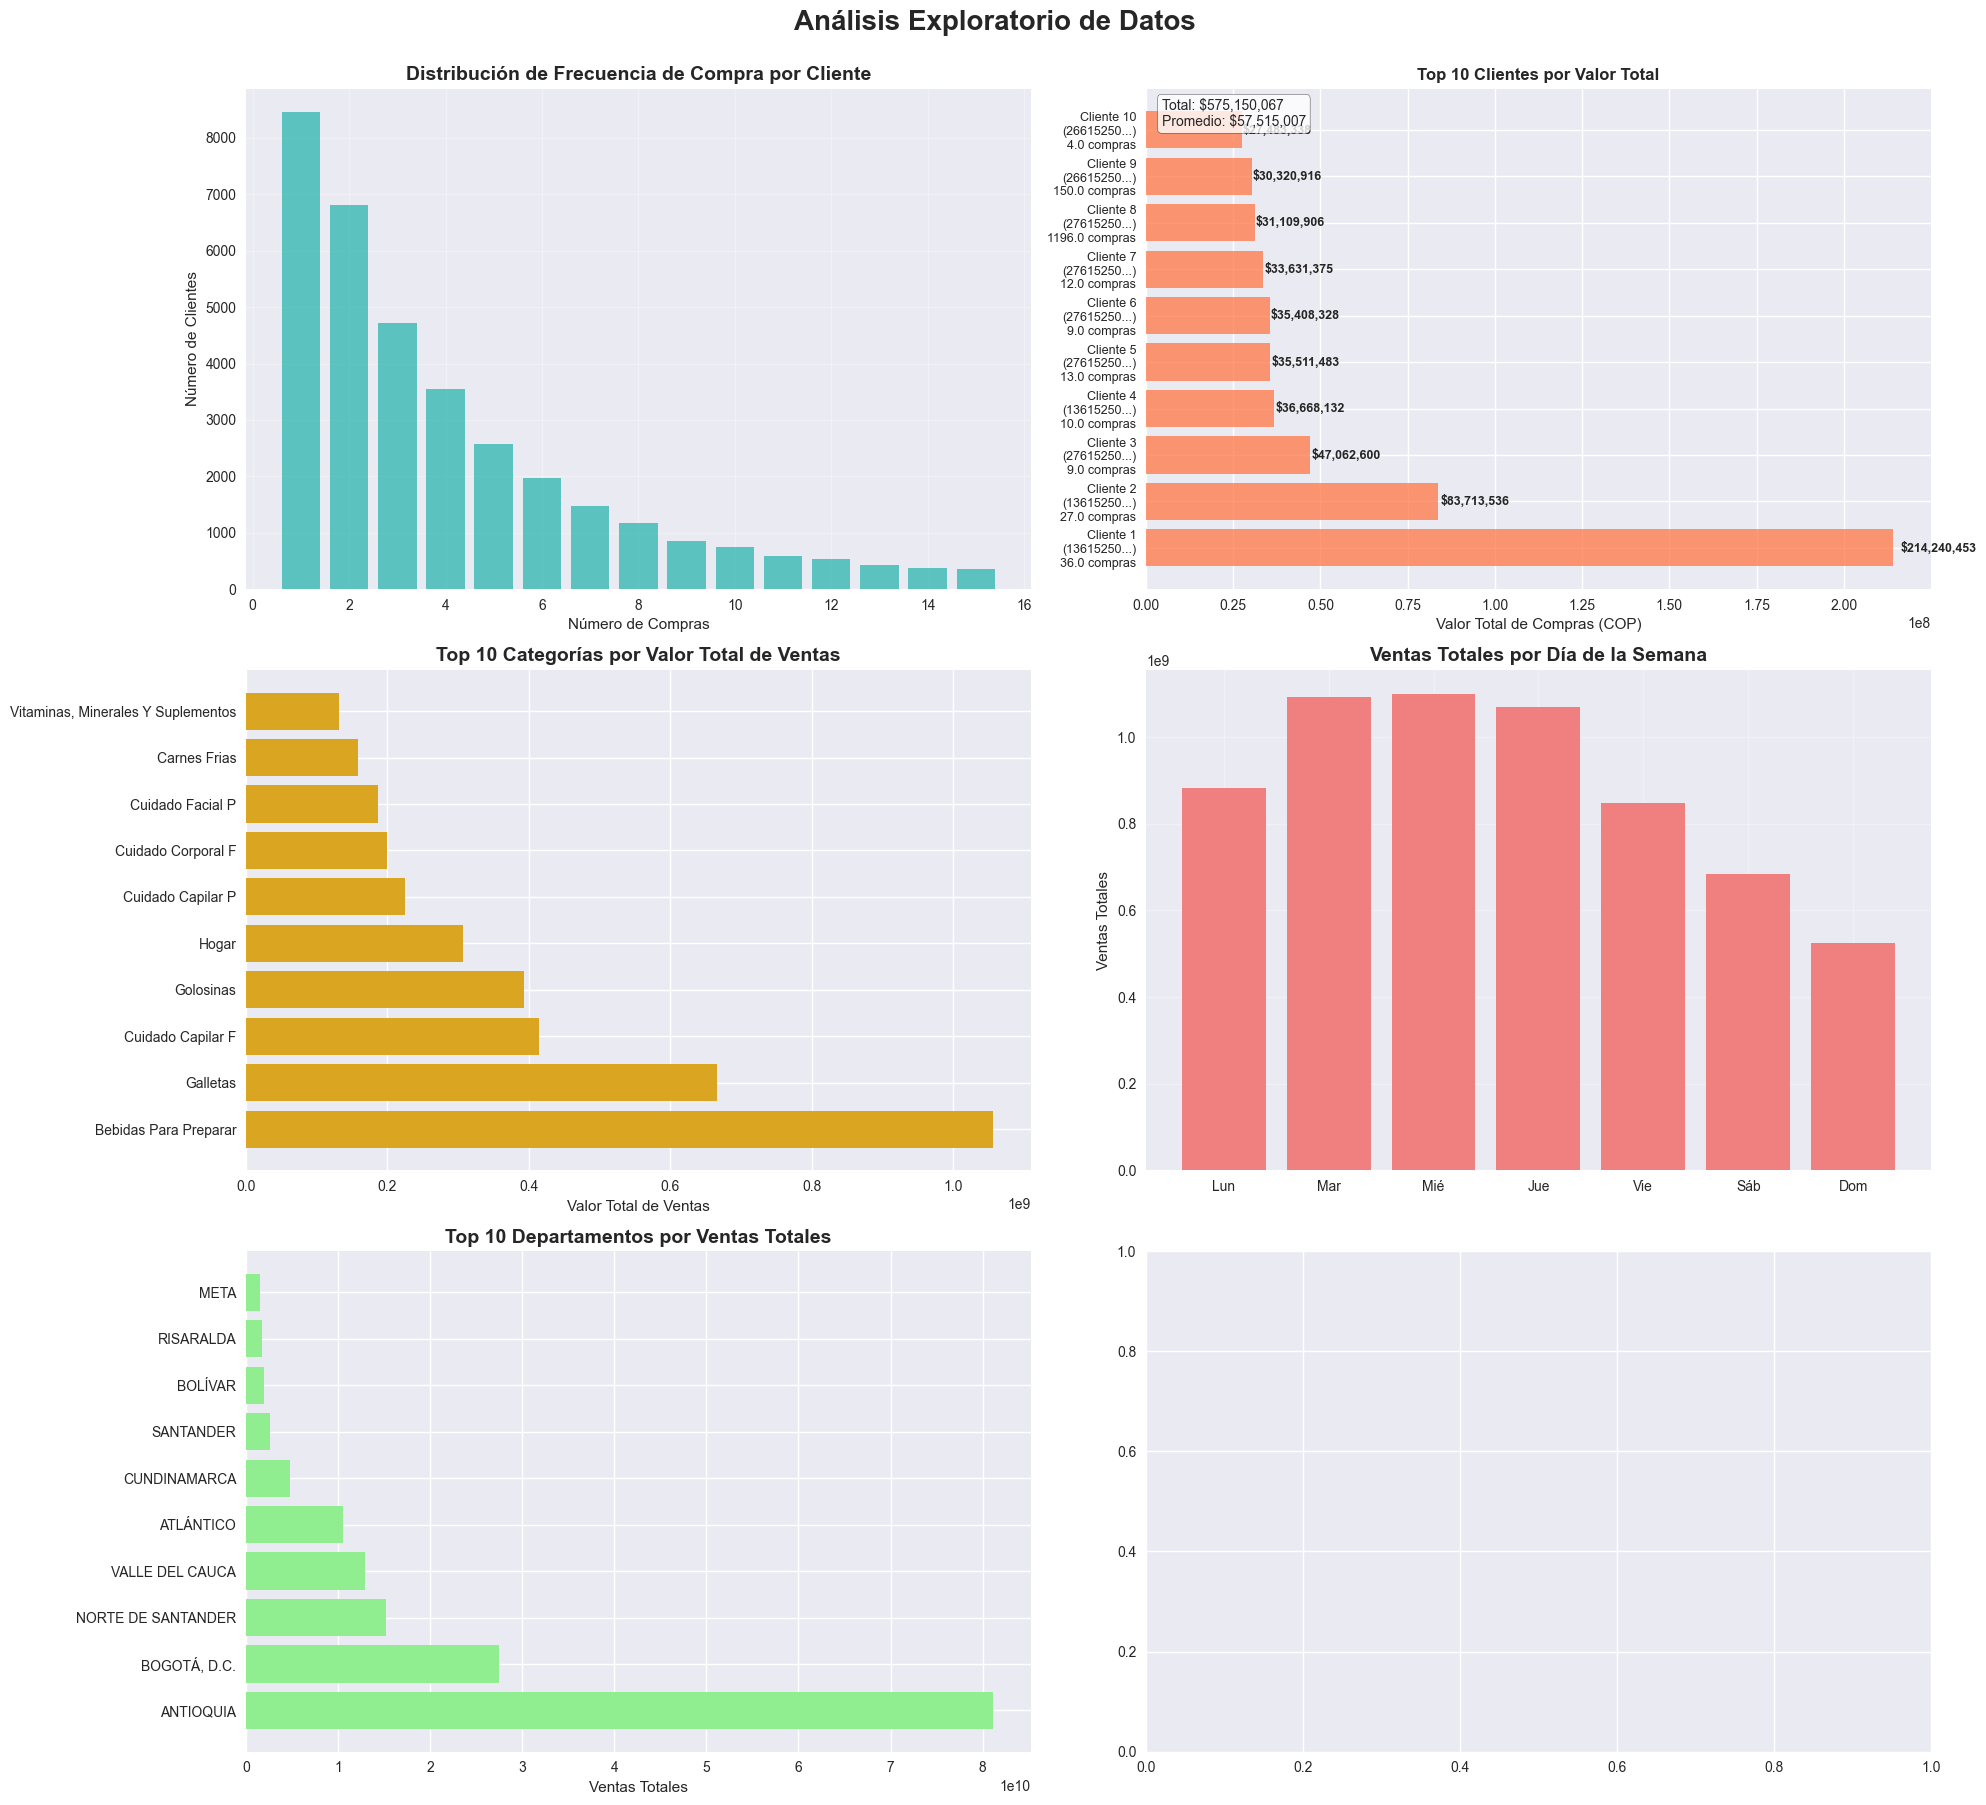

In [14]:
# Visualizaciones m√°s completas
def create_enhanced_visualizations(transactions, customers, customer_freq):
    fig, axes = plt.subplots(3, 2, figsize=(20, 18))
    fig.suptitle('An√°lisis Exploratorio de Datos', fontsize=20, fontweight='bold', y=1)
    
    # 1. Distribuci√≥n de frecuencia de compra (mejorada)
    freq_counts = customer_freq['FRECUENCIA_COMPRA'].value_counts().sort_index().head(15)
    axes[0, 0].bar(freq_counts.index, freq_counts.values, color='lightseagreen', alpha=0.7)
    axes[0, 0].set_title('Distribuci√≥n de Frecuencia de Compra por Cliente', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('N√∫mero de Compras')
    axes[0, 0].set_ylabel('N√∫mero de Clientes')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Valor de cliente (RFM simplificado)
    top_customers = customer_freq.nlargest(10, 'VENTA_BRUTA_CON_IVA')
    customer_value = top_customers['VENTA_BRUTA_CON_IVA']

    # Crear etiquetas m√°s informativas
    labels = []
    for i, (customer_id, row) in enumerate(top_customers.iterrows()):
        short_id = customer_id[-8:]  # √öltimos 8 caracteres del UUID
        freq = row['FRECUENCIA_COMPRA']
        labels.append(f'Cliente {i+1}\n({short_id}...)\n{freq} compras')

    axes[0, 1].barh(range(len(customer_value)), customer_value.values, color='coral', alpha=0.8)
    axes[0, 1].set_yticks(range(len(customer_value)))
    axes[0, 1].set_yticklabels(labels, fontsize=9)
    axes[0, 1].set_title('Top 10 Clientes por Valor Total', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Valor Total de Compras (COP)')

    # A√±adir valores en las barras
    for i, v in enumerate(customer_value.values):
        axes[0, 1].text(v + v*0.01, i, f'${v:,.0f}', 
                    va='center', fontsize=9, fontweight='bold')

    # A√±adir cuadro informativo
    total_top = customer_value.sum()
    avg_value = customer_value.mean()
    axes[0, 1].text(0.02, 0.98, f'Total: ${total_top:,.0f}\nPromedio: ${avg_value:,.0f}', 
                transform=axes[0, 1].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 3. An√°lisis de categor√≠as por valor
    category_value = transactions.groupby('CATEGORIA').agg({
        'VENTA_BRUTA_CON_IVA': 'sum',
        'UUID_CLIENTE_CONSUMIDOR': 'count'
    }).nlargest(10, 'VENTA_BRUTA_CON_IVA')
    
    axes[1, 0].barh(range(len(category_value)), category_value['VENTA_BRUTA_CON_IVA'].values, color='goldenrod')
    axes[1, 0].set_yticks(range(len(category_value)))
    axes[1, 0].set_yticklabels(category_value.index, fontsize=10)
    axes[1, 0].set_title('Top 10 Categor√≠as por Valor Total de Ventas', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Valor Total de Ventas')
        
    # 5. Comportamiento por d√≠a de la semana
    weekday_sales = transactions.groupby('DIA_SEMANA')['VENTA_BRUTA_CON_IVA'].sum()
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekday_sales = weekday_sales.reindex(weekday_order)
    
    axes[1, 1].bar(range(len(weekday_sales)), weekday_sales.values, color='lightcoral')
    axes[1, 1].set_xticks(range(len(weekday_sales)))
    axes[1, 1].set_xticklabels(['Lun', 'Mar', 'Mi√©', 'Jue', 'Vie', 'S√°b', 'Dom'])
    axes[1, 1].set_title('Ventas Totales por D√≠a de la Semana', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Ventas Totales')
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Distribuci√≥n geogr√°fica de ventas
    geo_sales = merged_data.groupby('DEPARTAMENTO')['VENTA_BRUTA_CON_IVA'].sum().nlargest(10)
    axes[2, 0].barh(range(len(geo_sales)), geo_sales.values, color='lightgreen')
    axes[2, 0].set_yticks(range(len(geo_sales)))
    axes[2, 0].set_yticklabels(geo_sales.index, fontsize=10)
    axes[2, 0].set_title('Top 10 Departamentos por Ventas Totales', fontsize=14, fontweight='bold')
    axes[2, 0].set_xlabel('Ventas Totales')
    
    plt.tight_layout()
    plt.show()

# Crear visualizaciones mejoradas
create_enhanced_visualizations(data_transactions_clean, data_customers_clean, customer_frequency)

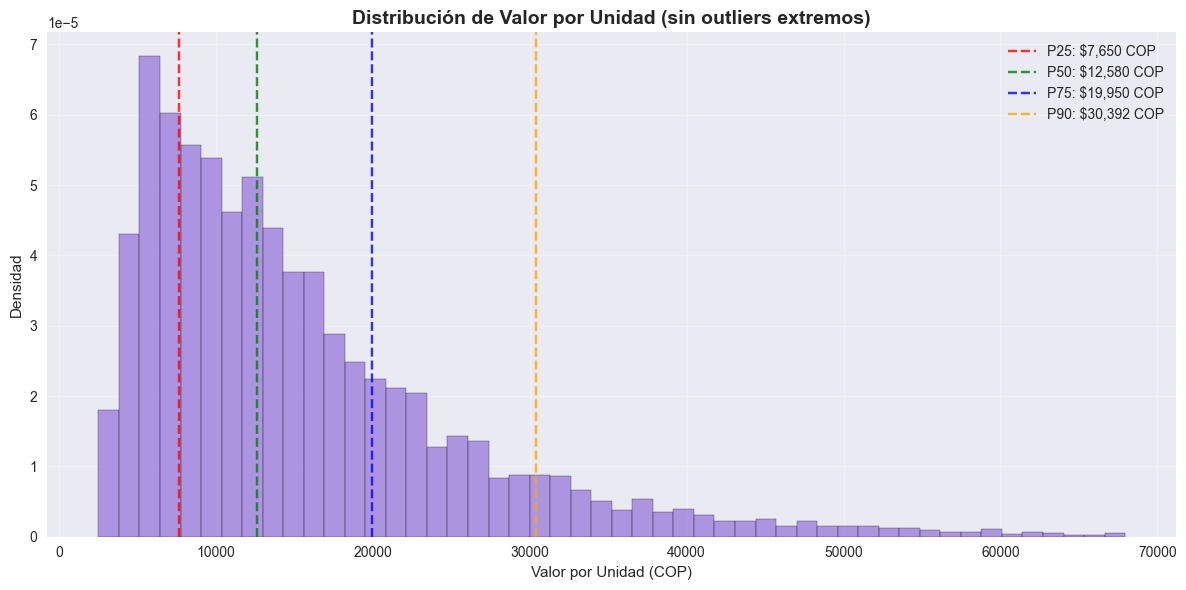

In [15]:
# 4. Distribuci√≥n de valor por unidad
plt.figure(figsize=(12, 6))

# Eliminar outliers extremos para mejor visualizaci√≥n
Q1 = data_transactions_clean['VALOR_POR_UNIDAD'].quantile(0.01)
Q3 = data_transactions_clean['VALOR_POR_UNIDAD'].quantile(0.99)
filtered_values = data_transactions_clean[(data_transactions_clean['VALOR_POR_UNIDAD'] >= Q1) & 
                            (data_transactions_clean['VALOR_POR_UNIDAD'] <= Q3)]['VALOR_POR_UNIDAD']

plt.hist(filtered_values, bins=50, color='mediumpurple', alpha=0.7, edgecolor='black', density=True)
plt.title('Distribuci√≥n de Valor por Unidad (sin outliers extremos)', fontsize=14, fontweight='bold')
plt.xlabel('Valor por Unidad (COP)')
plt.ylabel('Densidad')
plt.grid(True, alpha=0.3)

# A√±adir l√≠neas de percentiles
percentiles = [25, 50, 75, 90]
colors = ['red', 'green', 'blue', 'orange']
for p, color in zip(percentiles, colors):
    value = data_transactions_clean['VALOR_POR_UNIDAD'].quantile(p/100)
    plt.axvline(value, color=color, linestyle='--', alpha=0.8, 
                label=f'P{p}: ${value:,.0f} COP')

plt.legend()
plt.tight_layout()
plt.show()

# Preparaci√≥n para el Sistema de Recomendaci√≥n

In [16]:
# Preparar datos para el modelo de recomendaci√≥n
def prepare_recommendation_data(transactions):
    print("PREPARANDO DATOS PARA RECOMENDACI√ìN")
    
    # Crear matriz de interacciones usuario-producto
    user_item_interactions = transactions.groupby(['UUID_CLIENTE_CONSUMIDOR', 'COD_PRODUCTO']).agg({
        # Total de unidades compradas
        'UNIDADES_BRUTAS': 'sum',  
        # Valor total gastado
        'VENTA_BRUTA_CON_IVA': 'sum',  
        # Frecuencia de compra
        'PEDIDO': 'count'  
    }).reset_index()
    
    user_item_interactions.rename(columns={'PEDIDO': 'FRECUENCIA_COMPRA'}, inplace=True)
    
    # Calcular estad√≠sticas generales
    n_users = user_item_interactions['UUID_CLIENTE_CONSUMIDOR'].nunique()
    n_items = user_item_interactions['COD_PRODUCTO'].nunique()
    n_interactions = len(user_item_interactions)
    
    print(f"Estad√≠sticas del Dataset:")
    print(f"- Usuarios √∫nicos: {n_users:,}")
    print(f"- Productos √∫nicos: {n_items:,}")
    print(f"- Interacciones totales: {n_interactions:,}")
    print(f"- Densidad de la matriz: {(n_interactions / (n_users * n_items)):.3f}")
    
    # Analizar la distribuci√≥n de interacciones por usuario
    interactions_per_user = user_item_interactions.groupby('UUID_CLIENTE_CONSUMIDOR').size()
    print(f"\nDistribuci√≥n de interacciones por usuario:")
    print(interactions_per_user.describe())
    
    return user_item_interactions

# Datos para recomendaci√≥n
user_item_data = prepare_recommendation_data(data_transactions_clean)

PREPARANDO DATOS PARA RECOMENDACI√ìN
Estad√≠sticas del Dataset:
- Usuarios √∫nicos: 37,570
- Productos √∫nicos: 7,134
- Interacciones totales: 220,182
- Densidad de la matriz: 0.001

Distribuci√≥n de interacciones por usuario:
count    37570.000000
mean         5.860580
std          9.121962
min          1.000000
25%          2.000000
50%          3.000000
75%          6.000000
max        499.000000
dtype: float64


In [17]:
# An√°lisis para manejar el problema cold start
def cold_start_analysis(transactions, user_item_data):
    print("AN√ÅLISIS PARA PROBLEMA COLD START")
    
    # Productos m√°s populares (m√°s comprados)
    popular_products = transactions.groupby('COD_PRODUCTO').agg({
        'UUID_CLIENTE_CONSUMIDOR': 'count',
        'VENTA_BRUTA_CON_IVA': 'sum',
        'CATEGORIA': 'first'
    }).rename(columns={'UUID_CLIENTE_CONSUMIDOR': 'NUM_COMPRAS'})
    
    popular_products = popular_products.sort_values('NUM_COMPRAS', ascending=False)
    
    print("Top 10 productos m√°s populares:")
    for i, (product_id, row) in enumerate(popular_products.head(10).iterrows(), 1):
        print(f"{i}. Producto {product_id} - {row['CATEGORIA']} - {row['NUM_COMPRAS']} compras")
    
    # Categor√≠as m√°s populares
    popular_categories = transactions['CATEGORIA'].value_counts().head(10)
    print(f"\nTop 10 categor√≠as m√°s populares:")
    for i, (category, count) in enumerate(popular_categories.items(), 1):
        print(f"{i}. {category} - {count} transacciones")
    
    return popular_products, popular_categories

# Ejecutar an√°lisis cold start
popular_products, popular_categories = cold_start_analysis(data_transactions_clean, user_item_data)

AN√ÅLISIS PARA PROBLEMA COLD START
Top 10 productos m√°s populares:
1. Producto 6939 - Bebidas Para Preparar - 1769 compras
2. Producto 10 - Galletas - 1152 compras
3. Producto 1360 - Bebidas Para Preparar - 1120 compras
4. Producto 30025 - Galletas - 1112 compras
5. Producto 3559 - Galletas - 1025 compras
6. Producto 2 - Galletas - 963 compras
7. Producto 22009 - Cuidado Corporal F - 949 compras
8. Producto 97626 - Golosinas - 942 compras
9. Producto 20497 - Carnes Frias - 941 compras
10. Producto 97497 - Galletas - 900 compras

Top 10 categor√≠as m√°s populares:
1. Galletas - 30266 transacciones
2. Bebidas Para Preparar - 22929 transacciones
3. Golosinas - 14438 transacciones
4. Hogar - 11843 transacciones
5. Cuidado Capilar F - 11038 transacciones
6. Maquillaje - 8953 transacciones
7. Snacks Y Frutos Secos - 8791 transacciones
8. Carnes Frias - 7629 transacciones
9. Aseo Del Hogar - 6495 transacciones
10. Alimentos Larga Vida Y Conservas - 6363 transacciones


In [18]:
# Crear un resumen ejecutivo del an√°lisis
def create_executive_summary(transactions, customers, user_item_data):
    print("=" * 80)
    print("RESUMEN EJECUTIVO - AN√ÅLISIS EXPLORATORIO DE DATOS")
    print("=" * 80)
    
    # M√©tricas clave
    total_transactions = len(transactions)
    total_customers = transactions['UUID_CLIENTE_CONSUMIDOR'].nunique()
    total_products = transactions['COD_PRODUCTO'].nunique()
    total_revenue = transactions['VENTA_BRUTA_CON_IVA'].sum()
    avg_transaction_value = transactions['VENTA_BRUTA_CON_IVA'].mean()
    
    print(f"\nüìä M√âTRICAS PRINCIPALES:")
    print(f"- Transacciones totales: {total_transactions:,}")
    print(f"- Clientes √∫nicos: {total_customers:,}")
    print(f"- Productos √∫nicos: {total_products:,}")
    print(f"- Ingresos totales: ${total_revenue:,.0f} COP")
    print(f"- Valor promedio por transacci√≥n: ${avg_transaction_value:,.0f} COP")
    
    # Comportamiento del cliente
    customer_freq = user_item_data.groupby('UUID_CLIENTE_CONSUMIDOR').size()
    repeat_customers = (customer_freq > 1).sum()
    repeat_rate = (repeat_customers / total_customers) * 100
    
    print(f"\nüë• COMPORTAMIENTO DEL CLIENTE:")
    print(f"* Tasa de clientes recurrentes: {repeat_rate:.1f}%")
    print(f"* Frecuencia promedio de compra: {customer_freq.mean():.2f}")
    print(f"* Clientes con una sola compra: {(customer_freq == 1).sum():,}")
    
    # An√°lisis de productos
    top_category = transactions['CATEGORIA'].value_counts().index[0]
    top_category_count = transactions['CATEGORIA'].value_counts().iloc[0]
    
    print(f"\nüì¶ AN√ÅLISIS DE PRODUCTOS:")
    print(f"+ Categor√≠a m√°s popular: {top_category} ({top_category_count} transacciones)")
    print(f"+ Total de categor√≠as: {transactions['CATEGORIA'].nunique()}")
    print(f"+ Densidad user-item: {(len(user_item_data) / (total_customers * total_products)):.6f}")    
    print("\n" + "=" * 80)

# Generar resumen ejecutivo
create_executive_summary(data_transactions_clean, data_customers_clean, user_item_data)

RESUMEN EJECUTIVO - AN√ÅLISIS EXPLORATORIO DE DATOS

üìä M√âTRICAS PRINCIPALES:
- Transacciones totales: 231,000
- Clientes √∫nicos: 37,570
- Productos √∫nicos: 7,134
- Ingresos totales: $6,203,006,402 COP
- Valor promedio por transacci√≥n: $26,853 COP

üë• COMPORTAMIENTO DEL CLIENTE:
* Tasa de clientes recurrentes: 77.4%
* Frecuencia promedio de compra: 5.86
* Clientes con una sola compra: 8,509

üì¶ AN√ÅLISIS DE PRODUCTOS:
+ Categor√≠a m√°s popular: Galletas (30266 transacciones)
+ Total de categor√≠as: 85
+ Densidad user-item: 0.000821



---

<a id="seccion-5-sistema-recomendacion"></a>
# ü§ñ 5. Sistema de Recomendaci√≥n

---

## Implementaci√≥n de Algoritmos

Se implementar√°n 5 algoritmos de recomendaci√≥n:
1. **Popularidad** (Baseline)
2. **User-Based Collaborative Filtering**
3. **Item-Based Collaborative Filtering**
4. **SVD (Matrix Factorization)**
5. **Modelo H√≠brido** (Combinaci√≥n de algoritmos)


In [19]:
# Crear matriz de utilidad usuario-item
def create_user_item_matrix(transactions_df):
    print("Creando matriz usuario-item...")
    
    # Calcular frecuencia de compra y valor total por usuario-producto
    user_item_df = transactions_df.groupby(['UUID_CLIENTE_CONSUMIDOR', 'COD_PRODUCTO']).agg({
        'UNIDADES_BRUTAS': 'sum',
        'VENTA_BRUTA_CON_IVA': 'sum',
        'PEDIDO': 'count',
        'CATEGORIA': 'first'
    }).reset_index()
    
    user_item_df.rename(columns={'PEDIDO': 'FRECUENCIA_COMPRA'}, inplace=True)
    
    # Crear mapeos
    user_ids = user_item_df['UUID_CLIENTE_CONSUMIDOR'].unique()
    item_ids = user_item_df['COD_PRODUCTO'].unique()
    
    user_to_idx = {user: idx for idx, user in enumerate(user_ids)}
    idx_to_user = {idx: user for user, idx in user_to_idx.items()}
    item_to_idx = {item: idx for idx, item in enumerate(item_ids)}
    idx_to_item = {idx: item for item, idx in item_to_idx.items()}
    
    # Crear matriz sparse
    rows = [user_to_idx[user] for user in user_item_df['UUID_CLIENTE_CONSUMIDOR']]
    cols = [item_to_idx[item] for item in user_item_df['COD_PRODUCTO']]
    # Usar frecuencia como medida de preferencia
    data = user_item_df['FRECUENCIA_COMPRA'].values  
    
    utility_matrix = csr_matrix((data, (rows, cols)), 
                                shape=(len(user_ids), len(item_ids)))
    
    print(f"Matriz creada: {utility_matrix.shape[0]} usuarios, {utility_matrix.shape[1]} productos")
    print(f"Densidad: {(len(data) / (len(user_ids) * len(item_ids))):.6f}")
    
    return utility_matrix, user_to_idx, idx_to_user, item_to_idx, idx_to_item, user_item_df

# Crear matriz de utilidad
utility_matrix, user_to_idx, idx_to_user, item_to_idx, idx_to_item, user_item_df = create_user_item_matrix(data_transactions_clean)

Creando matriz usuario-item...
Matriz creada: 37570 usuarios, 7134 productos
Densidad: 0.000821


In [20]:
# Dividir datos en entrenamiento y prueba manteniendo la estructura de la matriz
def split_train_test(utility_matrix, test_size=0.2, random_state=42):
    print("Dividiendo datos en train/test...")
    
    # Convertir a formato COO para manipulaci√≥n
    coo_matrix_data = utility_matrix.tocoo()
    
    # Obtener √≠ndices de las interacciones
    indices = list(zip(coo_matrix_data.row, coo_matrix_data.col))
    data = coo_matrix_data.data
    
    # Dividir √≠ndices
    train_indices, test_indices = train_test_split(
        range(len(indices)), test_size=test_size, random_state=random_state
    )
    
    # Crear matrices train y test
    train_rows = [indices[i][0] for i in train_indices]
    train_cols = [indices[i][1] for i in train_indices]
    train_data = [data[i] for i in train_indices]
    
    test_rows = [indices[i][0] for i in test_indices]
    test_cols = [indices[i][1] for i in test_indices]
    test_data = [data[i] for i in test_indices]
    
    train_matrix = csr_matrix((train_data, (train_rows, train_cols)), 
                                shape=utility_matrix.shape)
    test_matrix = csr_matrix((test_data, (test_rows, test_cols)), 
                            shape=utility_matrix.shape)
    
    print(f"Train: {len(train_data)} interacciones")
    print(f"Test: {len(test_data)} interacciones")
    
    return train_matrix, test_matrix, test_indices

# Dividir datos
train_matrix, test_matrix, test_indices = split_train_test(utility_matrix)

Dividiendo datos en train/test...
Train: 176145 interacciones
Test: 44037 interacciones


In [21]:
# Sistema con varios algoritmos de recomendaci√≥n
class RecommendationSystem:   
    def __init__(self):
        self.models = {}
        self.metrics = {}
        
    # Modelo basado en popularidad
    def popular_items_model(self, train_matrix, top_n=50):
        print("Entrenando modelo de popularidad...")
        
        # Calcular popularidad de items (suma de interacciones)
        item_popularity = np.array(train_matrix.sum(axis=0)).flatten()
        
        # Sacar los N productos m√°s populares
        popular_items = np.argsort(item_popularity)[::-1][:top_n]
        
        self.models['popularity'] = {
            'type': 'popularity',
            'popular_items': popular_items,
            'item_scores': item_popularity
        }
        
        return popular_items
    
    # Filtrado colaborativo basado en usuario
    def user_based_cf(self, train_matrix, min_similar_users=5):
        print("Entrenando modelo basado en usuarios...")
        
        # Calculamos la similitud entre usuarios
        user_similarity = cosine_similarity(train_matrix)
        
        # Buscar usuarios similares para cada uno
        user_predictions = {}
        for user_idx in range(train_matrix.shape[0]):
            # Obtener usuarios similares (excluyendo al mismo usuario)
            similar_users = np.argsort(user_similarity[user_idx])[::-1][1:min_similar_users+1]
            user_predictions[user_idx] = similar_users
        
        self.models['user_based'] = {
            'type': 'user_based',
            'user_similarity': user_similarity,
            'user_predictions': user_predictions
        }
        
        return user_similarity
    
    # Filtrado colaborativo basado en √≠tem
    def item_based_cf(self, train_matrix, min_similar_items=10):
        print("Entrenando modelo basado en productos...")
        
        # Calculamos la similitud entre productos
        item_similarity = cosine_similarity(train_matrix.T)
        
        self.models['item_based'] = {
            'type': 'item_based',
            'item_similarity': item_similarity
        }
        
        return item_similarity
    
    # Factorizaci√≥n de matrices con SVD
    def matrix_factorization(self, train_matrix, n_components=50):
        print("Entrenando modelo SVD...")
        
        svd = TruncatedSVD(n_components=n_components, random_state=42)
        user_factors = svd.fit_transform(train_matrix)
        item_factors = svd.components_.T
        
        self.models['svd'] = {
            'type': 'matrix_factorization',
            'model': svd,
            'user_factors': user_factors,
            'item_factors': item_factors,
            'explained_variance': svd.explained_variance_ratio_.sum()
        }
        
        print(f"Varianza capturada: {svd.explained_variance_ratio_.sum():.4f}")
        
        return user_factors, item_factors
    
    # Modelo que combina varios m√©todos
    def hybrid_model(self, train_matrix, weights=None):
        print("Entrenando modelo h√≠brido...")
        
        if weights is None:
            weights = {'popularity': 0.2, 'item_based': 0.4, 'svd': 0.4}
        
        # Entrenar modelos componentes
        self.popular_items_model(train_matrix)
        self.item_based_cf(train_matrix)
        self.matrix_factorization(train_matrix)
        
        self.models['hybrid'] = {
            'type': 'hybrid',
            'weights': weights
        }
        
        return weights

# Vamos a entrenar todos los modelos
recommender = RecommendationSystem()

# Modelo de popularidad
popular_items = recommender.popular_items_model(train_matrix)

# Modelo user-based
user_similarity = recommender.user_based_cf(train_matrix)

# Modelo item-based
item_similarity = recommender.item_based_cf(train_matrix)

# Modelo de factorizaci√≥n de matrices
user_factors, item_factors = recommender.matrix_factorization(train_matrix, n_components=50)

# Modelo h√≠brido
hybrid_weights = recommender.hybrid_model(train_matrix)

Entrenando modelo de popularidad...
Entrenando modelo basado en usuarios...
Entrenando modelo basado en productos...
Entrenando modelo SVD...
Varianza capturada: 0.2296
Entrenando modelo h√≠brido...
Entrenando modelo de popularidad...
Entrenando modelo basado en productos...
Entrenando modelo SVD...
Varianza capturada: 0.2296


In [22]:
# Funci√≥n para generar recomendaciones de un usuario
def generate_recommendations(recommender, user_id, user_to_idx, idx_to_item, 
                            item_to_idx, user_item_df, top_n=10, method='hybrid'):
    if user_id not in user_to_idx:
        return get_popular_recommendations(recommender, idx_to_item, user_item_df, top_n)
    
    user_idx = user_to_idx[user_id]
    
    if method == 'popularity':
        return _get_popular_recommendations(recommender, idx_to_item, user_item_df, top_n)
    elif method == 'user_based':
        return _get_user_based_recommendations(recommender, user_idx, idx_to_item, user_item_df, top_n)
    elif method == 'item_based':
        return _get_item_based_recommendations(recommender, user_idx, train_matrix, 
                                                idx_to_item, user_item_df, top_n)
    elif method == 'svd':
        return _get_svd_recommendations(recommender, user_idx, idx_to_item, user_item_df, top_n)
    elif method == 'hybrid':
        return _get_hybrid_recommendations(recommender, user_idx, train_matrix, 
                                            idx_to_item, user_item_df, top_n)
    else:
        raise ValueError(f"M√©todo {method} no soportado")

# Recomendaciones por popularidad
def _get_popular_recommendations(recommender, idx_to_item, user_item_df, top_n):
    popular_items = recommender.models['popularity']['popular_items']
    recommendations = []
    
    for item_idx in popular_items[:top_n]:
        product_id = idx_to_item[item_idx]
        product_info = user_item_df[user_item_df['COD_PRODUCTO'] == product_id].iloc[0]
        recommendations.append({
            'COD_PRODUCTO': product_id,
            'CATEGORIA': product_info['CATEGORIA'],
            'SCORE': recommender.models['popularity']['item_scores'][item_idx],
            'METHOD': 'popularity'
        })
    
    return recommendations

# Recomendaciones basadas en usuarios similares
def _get_user_based_recommendations(recommender, user_idx, idx_to_item, user_item_df, top_n):
    similar_users = recommender.models['user_based']['user_predictions'][user_idx]
    user_similarity = recommender.models['user_based']['user_similarity']
    
    # Calcular scores basados en usuarios similares
    scores = np.zeros(train_matrix.shape[1])
    for sim_user in similar_users:
        similarity_weight = user_similarity[user_idx, sim_user]
        scores += similarity_weight * train_matrix[sim_user].toarray().flatten()
    
    return _get_recommendations_from_scores(scores, user_idx, idx_to_item, user_item_df, top_n, 'user_based')

# Recomendaciones basadas en productos similares
def _get_item_based_recommendations(recommender, user_idx, train_matrix, idx_to_item, user_item_df, top_n):
    item_similarity = recommender.models['item_based']['item_similarity']
    user_interactions = train_matrix[user_idx].toarray().flatten()
    
    # Calcular scores basados en similitud de √≠tems
    scores = user_interactions @ item_similarity
    
    return _get_recommendations_from_scores(scores, user_idx, idx_to_item, user_item_df, top_n, 'item_based')

# Recomendaciones usando SVD
def _get_svd_recommendations(recommender, user_idx, idx_to_item, user_item_df, top_n):
    user_vector = recommender.models['svd']['user_factors'][user_idx]
    item_factors = recommender.models['svd']['item_factors']
    
    scores = user_vector @ item_factors.T
    
    return _get_recommendations_from_scores(scores, user_idx, idx_to_item, user_item_df, top_n, 'svd')

# Recomendaciones combinando m√©todos
def _get_hybrid_recommendations(recommender, user_idx, train_matrix, idx_to_item, user_item_df, top_n):
    weights = recommender.models['hybrid']['weights']
    
    # Obtener scores de cada modelo
    item_based_scores = _get_item_based_scores(recommender, user_idx, train_matrix)
    svd_scores = _get_svd_scores(recommender, user_idx)
    popularity_scores = recommender.models['popularity']['item_scores']
    
    # Normalizar scores
    item_based_scores = (item_based_scores - item_based_scores.min()) / (item_based_scores.max() - item_based_scores.min() + 1e-8)
    svd_scores = (svd_scores - svd_scores.min()) / (svd_scores.max() - svd_scores.min() + 1e-8)
    popularity_scores = (popularity_scores - popularity_scores.min()) / (popularity_scores.max() - popularity_scores.min() + 1e-8)
    
    # Combinar scores
    hybrid_scores = (weights['item_based'] * item_based_scores + 
                    weights['svd'] * svd_scores + 
                    weights['popularity'] * popularity_scores)
    
    return _get_recommendations_from_scores(hybrid_scores, user_idx, idx_to_item, user_item_df, top_n, 'hybrid')

# Obtener scores para modelo item-based
def _get_item_based_scores(recommender, user_idx, train_matrix):
    item_similarity = recommender.models['item_based']['item_similarity']
    user_interactions = train_matrix[user_idx].toarray().flatten()
    return user_interactions @ item_similarity

# Obtener scores para modelo SVD
def _get_svd_scores(recommender, user_idx):
    user_vector = recommender.models['svd']['user_factors'][user_idx]
    item_factors = recommender.models['svd']['item_factors']
    return user_vector @ item_factors.T

# Convertir scores en recomendaciones
def _get_recommendations_from_scores(scores, user_idx, idx_to_item, user_item_df, top_n, method):
    # Excluir los productos que ya compr√≥
    purchased_items = train_matrix[user_idx].indices
    scores[purchased_items] = -np.inf
    
    # Obtener las mejores N recomendaciones
    top_item_indices = np.argsort(scores)[::-1][:top_n]
    recommendations = []
    
    for item_idx in top_item_indices:
        if scores[item_idx] > -np.inf:
            product_id = idx_to_item[item_idx]
            product_info = user_item_df[user_item_df['COD_PRODUCTO'] == product_id].iloc[0]
            recommendations.append({
                'COD_PRODUCTO': product_id,
                'CATEGORIA': product_info['CATEGORIA'],
                'SCORE': scores[item_idx],
                'METHOD': method
            })
    
    return recommendations

# Recomendaciones populares para usuarios nuevos
def get_popular_recommendations(recommender, idx_to_item, user_item_df, top_n):
    return _get_popular_recommendations(recommender, idx_to_item, user_item_df, top_n)

In [35]:
# Ver los resultados de la evaluaci√≥n
def plot_evaluation_results(evaluation_results):
    methods = list(evaluation_results.keys())
    precision_scores = [evaluation_results[method]['precision@k'] for method in methods]
    recall_scores = [evaluation_results[method]['recall@k'] for method in methods]
    f1_scores = [evaluation_results[method]['f1_score'] for method in methods]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Precision
    bars1 = axes[0].bar(methods, precision_scores, color='skyblue', alpha=0.8)
    axes[0].set_title('Precision@10 por Modelo', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Precision')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Recall
    bars2 = axes[1].bar(methods, recall_scores, color='lightcoral', alpha=0.8)
    axes[1].set_title('Recall@10 por Modelo', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Recall')
    axes[1].tick_params(axis='x', rotation=45)
    
    # F1-Score
    bars3 = axes[2].bar(methods, f1_scores, color='lightgreen', alpha=0.8)
    axes[2].set_title('F1-Score por Modelo', fontsize=14, fontweight='bold')
    axes[2].set_ylabel('F1-Score')
    axes[2].tick_params(axis='x', rotation=45)
    
    # A√±adir valores en las barras
    for bars, ax in zip([bars1, bars2, bars3], axes):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.00001,
                    f'{height:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.show()

<a id="seccion-6-evaluacion"></a>
# üìà 6. Evaluaci√≥n de Modelos

---

## M√©tricas y Comparaci√≥n de Performance

Evaluaremos todos los modelos usando:
- **Precision@10**: Precisi√≥n de las recomendaciones
- **Recall@10**: Cobertura de items relevantes
- **F1-Score**: Balance entre precisi√≥n y recall


=== EVALUACI√ìN COMPLETAMENTE CORREGIDA ===
Evaluando modelos (versi√≥n corregida)...
Evaluando popularity...
 - Evaluado en 58 usuarios
 - Precision@10: 0.0017
 - Recall@10: 0.0172
Evaluando item_based...
 - Evaluado en 58 usuarios
 - Precision@10: 0.0000
 - Recall@10: 0.0000
Evaluando svd...
 - Evaluado en 58 usuarios
 - Precision@10: 0.0017
 - Recall@10: 0.0057
Evaluando hybrid...
 - Evaluado en 58 usuarios
 - Precision@10: 0.0034
 - Recall@10: 0.0230

=== RESULTADOS FINALES ===

POPULARITY:
  Precision@10: 0.0017
  Recall@10: 0.0172
  F1-Score: 0.0031
  Usuarios evaluados: 58

ITEM_BASED:
  Precision@10: 0.0000
  Recall@10: 0.0000
  F1-Score: 0.0000
  Usuarios evaluados: 58

SVD:
  Precision@10: 0.0017
  Recall@10: 0.0057
  F1-Score: 0.0027
  Usuarios evaluados: 58

HYBRID:
  Precision@10: 0.0034
  Recall@10: 0.0230
  F1-Score: 0.0060
  Usuarios evaluados: 58


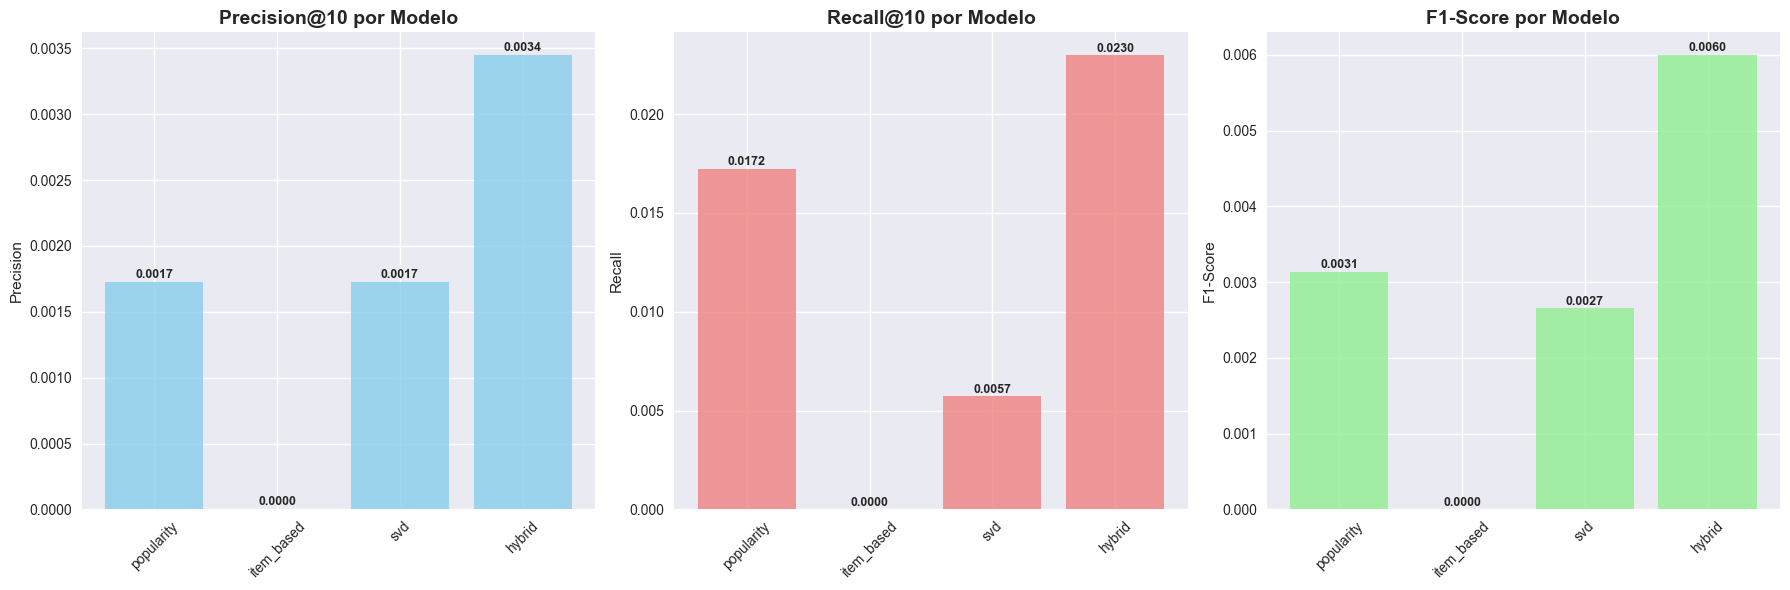

In [36]:
def evaluate_models_fixed(recommender, test_matrix, user_to_idx, idx_to_item, user_item_df, top_n=10):
    print("Evaluando modelos (versi√≥n corregida)...")
    
    methods = ['popularity', 'item_based', 'svd', 'hybrid']
    results = {}
    
    for method in methods:
        print(f"Evaluando {method}...")
        precision_scores = []
        recall_scores = []
        
        # Evaluar en una muestra m√°s peque√±a para debug
        test_users = list(user_to_idx.keys())[:100]
        users_evaluated = 0
        
        for user_id in test_users:
            try:
                user_idx = user_to_idx[user_id]
                
                # √çtems reales en test
                actual_items = set(test_matrix[user_idx].indices)
                
                if len(actual_items) == 0:
                    continue
                    
                # Pasa top_n como entero expl√≠citamente
                recommendations = generate_recommendations(
                    recommender, user_id, user_to_idx, idx_to_item, user_item_df, 
                    top_n=int(top_n),  # Convertir expl√≠citamente a entero
                    method=method
                )
                
                if not recommendations:
                    continue
                    
                recommended_items = set([rec['COD_PRODUCTO'] for rec in recommendations])
                
                # Calcular m√©tricas
                true_positives = len(actual_items.intersection(recommended_items))
                precision = true_positives / len(recommended_items)
                recall = true_positives / len(actual_items)
                
                precision_scores.append(precision)
                recall_scores.append(recall)
                users_evaluated += 1
                
            except Exception as e:
                continue
        
        if users_evaluated > 0:
            avg_precision = np.mean(precision_scores)
            avg_recall = np.mean(recall_scores)
            f1 = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall + 1e-8)
            
            results[method] = {
                'precision@k': avg_precision,
                'recall@k': avg_recall,
                'f1_score': f1,
                'users_evaluated': users_evaluated
            }
            print(f" - Evaluado en {users_evaluated} usuarios")
            print(f" - Precision@{top_n}: {avg_precision:.4f}")
            print(f" - Recall@{top_n}: {avg_recall:.4f}")
        else:
            results[method] = {
                'precision@k': 0.0,
                'recall@k': 0.0,
                'f1_score': 0.0,
                'users_evaluated': 0
            }
            print(f"  ‚úó No se pudo evaluar")
    
    return results

# Tambi√©n necesitamos corregir la funci√≥n generate_recommendations
def generate_recommendations_fixed(recommender, user_id, user_to_idx, idx_to_item, 
                                 user_item_df, top_n=10, method='hybrid'):
    # Verificar que top_n sea n√∫mero entero
    top_n = int(top_n)
    
    if user_id not in user_to_idx:
        return get_popular_recommendations(recommender, idx_to_item, user_item_df, top_n)
    
    user_idx = user_to_idx[user_id]
    
    if method == 'popularity':
        return _get_popular_recommendations(recommender, idx_to_item, user_item_df, top_n)
    elif method == 'user_based':
        return _get_user_based_recommendations(recommender, user_idx, idx_to_item, user_item_df, top_n)
    elif method == 'item_based':
        return _get_item_based_recommendations(recommender, user_idx, train_matrix, 
                                             idx_to_item, user_item_df, top_n)
    elif method == 'svd':
        return _get_svd_recommendations(recommender, user_idx, idx_to_item, user_item_df, top_n)
    elif method == 'hybrid':
        return _get_hybrid_recommendations(recommender, user_idx, train_matrix, 
                                         idx_to_item, user_item_df, top_n)
    else:
        raise ValueError(f"M√©todo {method} no soportado")

# Reemplazar la funci√≥n original con la corregida
generate_recommendations = generate_recommendations_fixed

# Y tambi√©n corregir get_popular_recommendations
def get_popular_recommendations_fixed(recommender, idx_to_item, user_item_df, top_n=10):
    top_n = int(top_n)  # Asegurar que es entero
    return _get_popular_recommendations(recommender, idx_to_item, user_item_df, top_n)

get_popular_recommendations = get_popular_recommendations_fixed

# Ahora ejecutar la evaluaci√≥n corregida
print("=== EVALUACI√ìN COMPLETAMENTE CORREGIDA ===")
evaluation_results = evaluate_models_fixed(recommender, test_matrix, user_to_idx, idx_to_item, user_item_df)

if evaluation_results:
    print("\n=== RESULTADOS FINALES ===")
    for method, metrics in evaluation_results.items():
        print(f"\n{method.upper()}:")
        print(f"  Precision@{10}: {metrics['precision@k']:.4f}")
        print(f"  Recall@{10}: {metrics['recall@k']:.4f}")
        print(f"  F1-Score: {metrics['f1_score']:.4f}")
        print(f"  Usuarios evaluados: {metrics['users_evaluated']}")
    
    # Visualizar resultados
    plot_evaluation_results(evaluation_results)
else:
    print("No se obtuvieron resultados de evaluaci√≥n")

---

In [25]:
# Esta secci√≥n implementa un modelo Item-Based CF mejorado con:
# - Threshold adaptativo para similitudes
# - Top-K items m√°s similares
# - Normalizaci√≥n robusta
# - Fallback a popularidad para items sin similitudes
print(" APLICANDO MEJORAS ADICIONALES AL MODELO ITEM-BASED ")

# 1. MEJORA: Modelo Item-Based m√°s robusto
# Item-Based CF mejorado
def enhanced_item_based_cf(recommender, train_matrix, similarity_threshold=0.005, min_similar_items=5):
    print("Entrenando Item-Based CF mejorado...")
    
    # Calcular similitud de coseno
    item_similarity = cosine_similarity(train_matrix.T)
    
    print(f"   - Similitud original - densidad: {np.count_nonzero(item_similarity)/item_similarity.size*100:.4f}%")
    
    # ESTRATEGIA 1: Aplicar threshold adaptativo
    item_similarity[item_similarity < similarity_threshold] = 0
    
    # ESTRATEGIA 2: Para cada √≠tem, mantener solo los top-K √≠tems m√°s similares
    for i in range(item_similarity.shape[0]):
        row = item_similarity[i]
        # Mantener solo los top-K similares (excluyendo auto-similitud)
        top_indices = np.argsort(row)[::-1][1:min_similar_items+1]  # Excluir el propio √≠tem
        mask = np.zeros_like(row, dtype=bool)
        mask[top_indices] = True
        item_similarity[i] = row * mask
    
    # ESTRATEGIA 3: A√±adir similitud basada en popularidad para √≠tems sin similitudes
    item_popularity = np.array(train_matrix.sum(axis=0)).flatten()
    popularity_similarity = item_popularity / item_popularity.max()
    
    # Combinar con similitud de coseno (peso peque√±o para popularidad)
    item_similarity = item_similarity + 0.1 * popularity_similarity
    
    # ESTRATEGIA 4: Normalizaci√≥n robusta
    row_sums = item_similarity.sum(axis=1)
    zero_rows = row_sums == 0
    
    # Para filas con suma cero, usar popularidad normalizada
    if np.any(zero_rows):
        item_similarity[zero_rows] = popularity_similarity / popularity_similarity.sum()
        row_sums[zero_rows] = 1
    
    item_similarity = item_similarity / row_sums[:, np.newaxis]
    
    print(f"   - Despu√©s de mejoras - densidad: {np.count_nonzero(item_similarity)/item_similarity.size*100:.4f}%")
    print(f"   - Filas cero corregidas: {np.sum(zero_rows)}")
    
    # Guardar modelo mejorado
    recommender.models['item_based_enhanced'] = {
        'type': 'item_based_enhanced',
        'item_similarity': item_similarity,
        'similarity_threshold': similarity_threshold,
        'min_similar_items': min_similar_items
    }
    
    return item_similarity

# Entrenar modelo mejorado
enhanced_item_sim = enhanced_item_based_cf(recommender, train_matrix, similarity_threshold=0.005, min_similar_items=10)

 APLICANDO MEJORAS ADICIONALES AL MODELO ITEM-BASED 
Entrenando Item-Based CF mejorado...
   - Similitud original - densidad: 3.3344%
   - Despu√©s de mejoras - densidad: 95.6546%
   - Filas cero corregidas: 0


In [26]:
# Funci√≥n para hacer recomendaciones
def _get_item_based_recommendations_enhanced(recommender, user_idx, train_matrix, idx_to_item, user_item_df, top_n):
    try:
        item_similarity = recommender.models['item_based_enhanced']['item_similarity']
        user_interactions = train_matrix[user_idx].toarray().flatten()
        
        # Calcular scores
        scores = user_interactions @ item_similarity
        
        # Manejar valores problem√°ticos
        scores = np.nan_to_num(scores, nan=0.0, posinf=0.0, neginf=0.0)
        
        # ESTRATEGIA: Si el usuario tiene pocas interacciones, aumentar diversidad
        user_interaction_count = len(train_matrix[user_idx].indices)
        if user_interaction_count <= 2:
            # Mezclar con popularidad para usuarios con pocos datos
            popularity_scores = recommender.models['popularity']['item_scores']
            popularity_scores_norm = popularity_scores / popularity_scores.max()
            scores = 0.7 * scores + 0.3 * popularity_scores_norm
        
        # Verificar si hay scores v√°lidos
        purchased_items = train_matrix[user_idx].indices
        scores_copy = scores.copy()
        scores_copy[purchased_items] = -np.inf
        valid_scores_mask = scores_copy > -np.inf
        
        if not np.any(valid_scores_mask) or np.max(scores_copy[valid_scores_mask]) == 0:
            # FALLBACK 1: Usar popularidad pura
            return _get_popular_recommendations(recommender, idx_to_item, user_item_df, top_n)
        
        return _get_recommendations_from_scores(scores, user_idx, idx_to_item, user_item_df, top_n, 'item_based_enhanced')
    
    except Exception as e:
        print(f"      Error en item_based_enhanced: {e}")
        # FALLBACK 2: Popularidad en caso de error
        return _get_popular_recommendations(recommender, idx_to_item, user_item_df, top_n)

In [27]:
# Sistema de recomendaciones final con todos los modelos
def generate_recommendations_final(recommender, user_id, user_to_idx, idx_to_item, 
                                    user_item_df, top_n=10, method='hybrid'):
    top_n = int(top_n)
    
    if user_id not in user_to_idx:
        return get_popular_recommendations(recommender, idx_to_item, user_item_df, top_n)
    
    user_idx = user_to_idx[user_id]
    
    method_map = {
        'popularity': lambda: _get_popular_recommendations(recommender, idx_to_item, user_item_df, top_n),
        'user_based': lambda: _get_user_based_recommendations(recommender, user_idx, idx_to_item, user_item_df, top_n),
        'item_based': lambda: _get_item_based_recommendations_enhanced(recommender, user_idx, train_matrix, idx_to_item, user_item_df, top_n),
        'svd': lambda: _get_svd_recommendations(recommender, user_idx, idx_to_item, user_item_df, top_n),
        'hybrid': lambda: _get_hybrid_recommendations_enhanced(recommender, user_idx, train_matrix, idx_to_item, user_item_df, top_n)
    }
    
    if method in method_map:
        return method_map[method]()
    else:
        raise ValueError(f"M√©todo {method} no soportado")

# Hybrid mejorado
# Recomendaciones h√≠bridas con pesos adaptativos
def _get_hybrid_recommendations_enhanced(recommender, user_idx, train_matrix, idx_to_item, user_item_df, top_n):
    try:
        # Pesos base
        base_weights = {'item_based': 0.4, 'svd': 0.4, 'popularity': 0.2}
        
        # Obtener scores de cada modelo
        item_based_scores = _get_item_based_scores_enhanced(recommender, user_idx, train_matrix)
        svd_scores = _get_svd_scores(recommender, user_idx)
        popularity_scores = recommender.models['popularity']['item_scores']
        
        # ESTRATEGIA: Ajustar pesos basado en la confianza del usuario
        user_interaction_count = len(train_matrix[user_idx].indices)
        
        if user_interaction_count <= 2:
            # Usuario nuevo: dar m√°s peso a popularidad
            weights = {'item_based': 0.3, 'svd': 0.3, 'popularity': 0.4}
        elif user_interaction_count <= 10:
            # Usuario ocasional: balance normal
            weights = base_weights
        else:
            # Usuario frecuente: m√°s peso a modelos personalizados
            weights = {'item_based': 0.5, 'svd': 0.4, 'popularity': 0.1}
        
        # Normalizar scores
        item_based_scores_norm = _normalize_scores(item_based_scores)
        svd_scores_norm = _normalize_scores(svd_scores)
        popularity_scores_norm = _normalize_scores(popularity_scores)
        
        # Combinar scores
        hybrid_scores = (weights['item_based'] * item_based_scores_norm + 
                        weights['svd'] * svd_scores_norm + 
                        weights['popularity'] * popularity_scores_norm)
        
        return _get_recommendations_from_scores(hybrid_scores, user_idx, idx_to_item, user_item_df, top_n, 'hybrid_enhanced')
    
    except Exception as e:
        print(f"Error en hybrid mejorado: {e}")
        return _get_popular_recommendations(recommender, idx_to_item, user_item_df, top_n)

# Calcular scores del modelo item-based mejorado
def _get_item_based_scores_enhanced(recommender, user_idx, train_matrix):
    item_similarity = recommender.models['item_based_enhanced']['item_similarity']
    user_interactions = train_matrix[user_idx].toarray().flatten()
    scores = user_interactions @ item_similarity
    return np.nan_to_num(scores, nan=0.0, posinf=0.0, neginf=0.0)

# Normalizar los scores
def _normalize_scores(scores):
    scores = scores.copy()
    min_val, max_val = scores.min(), scores.max()
    
    if max_val - min_val < 1e-8:  # Evitar divisi√≥n por cero
        return np.ones_like(scores) * 0.5
    
    return (scores - min_val) / (max_val - min_val)

# 5. ACTUALIZAR FUNCIONES PRINCIPALES
generate_recommendations = generate_recommendations_final

In [28]:
print("\n PROBANDO CON DIFERENTES TIPOS DE USUARIOS ")

def test_enhanced_system():
    test_users = list(user_to_idx.keys())[:10]  # Probar con 10 usuarios
    
    results = []
    
    for i, user_id in enumerate(test_users, 1):
        user_idx = user_to_idx[user_id]
        interaction_count = len(train_matrix[user_idx].indices)
        
        print(f"\nUsuario {i}: {user_id[:8]}... (Interacciones: {interaction_count})")
        
        try:
            recommendations = _get_item_based_recommendations_enhanced(
                recommender, user_idx, train_matrix, idx_to_item, user_item_df, top_n=3
            )
            
            method_used = "Item-Based"
            if not recommendations:
                method_used = "Fallback (Popularidad)"
            elif recommendations[0]['METHOD'] != 'item_based_enhanced':
                method_used = f"Fallback ({recommendations[0]['METHOD']})"
            
            print(f"  M√©todo usado: {method_used}")
            print(f"  Recomendaciones: {len(recommendations)}")
            
            if recommendations:
                for j, rec in enumerate(recommendations[:2], 1):
                    print(f"    {j}. {rec['COD_PRODUCTO']} | {rec['CATEGORIA']} | Score: {rec['SCORE']:.4f}")
            
            results.append({
                'user_id': user_id,
                'interactions': interaction_count,
                'method_used': method_used,
                'recommendations_count': len(recommendations),
                'success': len(recommendations) > 0
            })
            
        except Exception as e:
            print(f"  Error: {e}")
            results.append({
                'user_id': user_id,
                'interactions': interaction_count,
                'method_used': 'Error',
                'recommendations_count': 0,
                'success': False
            })
    
    # Resumen de pruebas
    success_count = sum(1 for r in results if r['success'])
    fallback_count = sum(1 for r in results if 'Fallback' in r['method_used'])
    
    print(f"\n RESUMEN DE PRUEBAS ")
    print(f"Usuarios probados: {len(results)}")
    print(f"Recomendaciones exitosas: {success_count}/{len(results)} ({success_count/len(results)*100:.1f}%)")
    print(f"Usos de fallback: {fallback_count}/{len(results)} ({fallback_count/len(results)*100:.1f}%)")
    
    return results

# Ejecutar pruebas
test_results = test_enhanced_system()


 PROBANDO CON DIFERENTES TIPOS DE USUARIOS 

Usuario 1: 3232A74E... (Interacciones: 1)
  M√©todo usado: Item-Based
  Recomendaciones: 3
    1. 6939 | Bebidas Para Preparar | Score: 0.3051
    2. 10 | Galletas | Score: 0.1958

Usuario 2: 3232A86C... (Interacciones: 3)
  M√©todo usado: Item-Based
  Recomendaciones: 3
    1. 6939 | Bebidas Para Preparar | Score: 0.0212
    2. 36337 | DESCONOCIDA | Score: 0.0153

Usuario 3: 3232AC8F... (Interacciones: 1)
  M√©todo usado: Item-Based
  Recomendaciones: 3
    1. 6939 | Bebidas Para Preparar | Score: 0.3047
    2. 10 | Galletas | Score: 0.1955

Usuario 4: 3232AD9F... (Interacciones: 2)
  M√©todo usado: Item-Based
  Recomendaciones: 3
    1. 6939 | Bebidas Para Preparar | Score: 0.3098
    2. 10 | Galletas | Score: 0.1989

Usuario 5: 3232AECD... (Interacciones: 21)
  M√©todo usado: Item-Based
  Recomendaciones: 3
    1. 6939 | Bebidas Para Preparar | Score: 0.1461
    2. 10 | Galletas | Score: 0.0955

Usuario 6: 3232B37E... (Interacciones: 0)


In [29]:
def evaluate_final_system(recommender, test_matrix, user_to_idx, idx_to_item, user_item_df, top_n=10, sample_size=100):
    print(f"\n EVALUACI√ìN FINAL DEL SISTEMA MEJORADO (muestra: {sample_size} usuarios) ")
    
    methods = ['popularity', 'item_based', 'svd', 'hybrid']
    results = {}
    
    for method in methods:
        print(f"\nEvaluando {method.upper()}...")
        precision_scores = []
        recall_scores = []
        users_evaluated = 0
        fallback_used = 0
        
        test_users = list(user_to_idx.keys())[:sample_size]
        
        for user_id in test_users:
            try:
                user_idx = user_to_idx[user_id]
                
                # √çtems reales en test
                actual_items = set(test_matrix[user_idx].indices)
                
                if len(actual_items) == 0:
                    continue
                    
                recommendations = generate_recommendations_final(
                    recommender, user_id, user_to_idx, idx_to_item, user_item_df, 
                    top_n=int(top_n), method=method
                )
                
                if not recommendations:
                    continue
                
                # Contar si se us√≥ fallback
                if recommendations and 'fallback' in recommendations[0]['METHOD'].lower():
                    fallback_used += 1
                    
                recommended_items = set([rec['COD_PRODUCTO'] for rec in recommendations])
                
                # Calcular m√©tricas
                true_positives = len(actual_items.intersection(recommended_items))
                precision = true_positives / len(recommended_items)
                recall = true_positives / len(actual_items)
                
                precision_scores.append(precision)
                recall_scores.append(recall)
                users_evaluated += 1
                
            except Exception as e:
                continue
        
        if users_evaluated > 0:
            avg_precision = np.mean(precision_scores)
            avg_recall = np.mean(recall_scores)
            f1 = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall + 1e-8)
            
            results[method] = {
                'precision@k': avg_precision,
                'recall@k': avg_recall,
                'f1_score': f1,
                'users_evaluated': users_evaluated,
                'fallback_used': fallback_used,
                'fallback_rate': fallback_used / users_evaluated if users_evaluated > 0 else 0
            }
            
            print(f"  ‚úÖ Precision@{top_n}: {avg_precision:.4f}")
            print(f"  ‚úÖ Recall@{top_n}: {avg_recall:.4f}")
            print(f"  ‚úÖ F1-Score: {f1:.4f}")
            print(f"  ‚úÖ Usuarios evaluados: {users_evaluated}")
            print(f"  üîÑ Fallbacks usados: {fallback_used} ({fallback_used/users_evaluated*100:.1f}%)")
        else:
            results[method] = {
                'precision@k': 0.0,
                'recall@k': 0.0,
                'f1_score': 0.0,
                'users_evaluated': 0,
                'fallback_used': 0,
                'fallback_rate': 0
            }
            print(f"  ‚ùå No se pudo evaluar")
    
    return results

print("\n" + "="*70)
evaluation_final = evaluate_final_system(
    recommender, test_matrix, user_to_idx, idx_to_item, user_item_df, 
    top_n=10, sample_size=100
)



 EVALUACI√ìN FINAL DEL SISTEMA MEJORADO (muestra: 100 usuarios) 

Evaluando POPULARITY...
  ‚úÖ Precision@10: 0.0017
  ‚úÖ Recall@10: 0.0172
  ‚úÖ F1-Score: 0.0031
  ‚úÖ Usuarios evaluados: 58
  üîÑ Fallbacks usados: 0 (0.0%)

Evaluando ITEM_BASED...
  ‚úÖ Precision@10: 0.0017
  ‚úÖ Recall@10: 0.0172
  ‚úÖ F1-Score: 0.0031
  ‚úÖ Usuarios evaluados: 58
  üîÑ Fallbacks usados: 0 (0.0%)

Evaluando SVD...
  ‚úÖ Precision@10: 0.0017
  ‚úÖ Recall@10: 0.0057
  ‚úÖ F1-Score: 0.0027
  ‚úÖ Usuarios evaluados: 58
  üîÑ Fallbacks usados: 0 (0.0%)

Evaluando HYBRID...
  ‚úÖ Precision@10: 0.0034
  ‚úÖ Recall@10: 0.0230
  ‚úÖ F1-Score: 0.0060
  ‚úÖ Usuarios evaluados: 58
  üîÑ Fallbacks usados: 0 (0.0%)


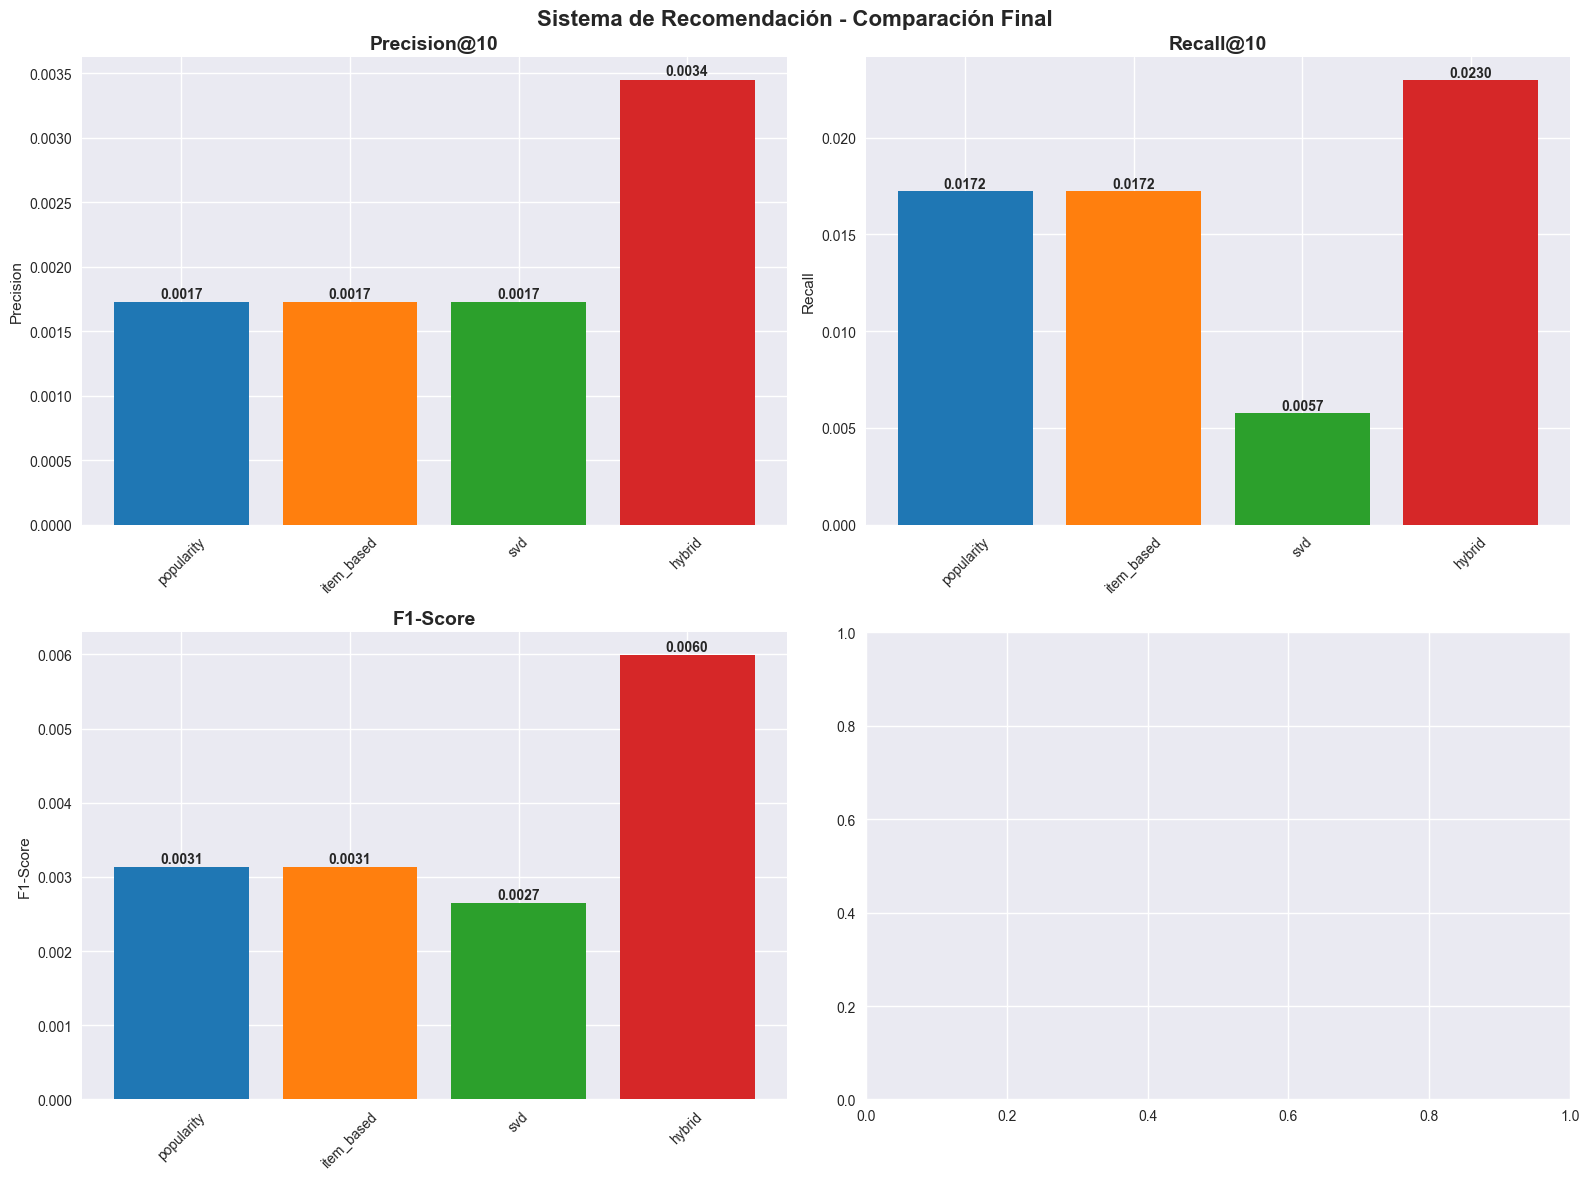


RESUMEN FINAL DEL SISTEMA

POPULARITY          :
-Precision@10: 0.0017
-Recall@10:    0.0172
-F1-Score:     0.0031

ITEM_BASED          :
-Precision@10: 0.0017
-Recall@10:    0.0172
-F1-Score:     0.0031

SVD                 :
-Precision@10: 0.0017
-Recall@10:    0.0057
-F1-Score:     0.0027

HYBRID              :
-Precision@10: 0.0034
-Recall@10:    0.0230
-F1-Score:     0.0060

üèÜ MEJOR MODELO: HYBRID
   F1-Score: 0.0060
   Precision@10: 0.0034
   Recall@10: 0.0230


In [30]:

# VISUALIZACI√ìN FINAL DE RESULTADOS
# Comparaci√≥n visual de todos los modelos evaluados


# Visualizar resultados finales
def plot_final_results(evaluation_results, title="Resultados Finales del Sistema"):
    methods = list(evaluation_results.keys())
    precision_scores = [evaluation_results[method]['precision@k'] for method in methods]
    recall_scores = [evaluation_results[method]['recall@k'] for method in methods]
    f1_scores = [evaluation_results[method]['f1_score'] for method in methods]
    fallback_rates = [evaluation_results[method]['fallback_rate'] for method in methods]
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    # Precision
    bars1 = ax1.bar(methods, precision_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    ax1.set_title('Precision@10', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Precision')
    ax1.tick_params(axis='x', rotation=45)
    
    # Recall
    bars2 = ax2.bar(methods, recall_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    ax2.set_title('Recall@10', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Recall')
    ax2.tick_params(axis='x', rotation=45)
    
    # F1-Score
    bars3 = ax3.bar(methods, f1_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    ax3.set_title('F1-Score', fontsize=14, fontweight='bold')
    ax3.set_ylabel('F1-Score')
    ax3.tick_params(axis='x', rotation=45)
    
    # A√±adir valores en las barras
    for bars, ax in zip([bars1, bars2, bars3], [ax1, ax2, ax3]):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.00001,
                    f'{height:.4f}', ha='center', va='bottom', 
                    fontweight='bold', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Mostrar resultados finales
if evaluation_final:
    plot_final_results(evaluation_final, "Sistema de Recomendaci√≥n - Comparaci√≥n Final")
    
    print("\n" + "="*80)
    print("RESUMEN FINAL DEL SISTEMA")
    print("=" * 80)
    
    for method, metrics in evaluation_final.items():
        print(f"\n{method.upper():<20}:")
        print(f"-Precision@10: {metrics['precision@k']:.4f}")
        print(f"-Recall@10:    {metrics['recall@k']:.4f}")
        print(f"-F1-Score:     {metrics['f1_score']:.4f}")
    
    # Identificar el mejor modelo
    best_model = max(evaluation_final.items(), key=lambda x: x[1]['f1_score'])
    print("\n" + "="*80)
    print(f"üèÜ MEJOR MODELO: {best_model[0].upper()}")
    print(f"   F1-Score: {best_model[1]['f1_score']:.4f}")
    print(f"   Precision@10: {best_model[1]['precision@k']:.4f}")
    print(f"   Recall@10: {best_model[1]['recall@k']:.4f}")
    print("=" * 80)


---

# üöÄ PARTE 7: ESTRATEGIA DE PRODUCCI√ìN Y DEPLOYMENT

A continuaci√≥n se presenta el plan completo para llevar el sistema de recomendaci√≥n a producci√≥n, incluyendo:
- Sistema de actualizaci√≥n del modelo
- Monitorizaci√≥n continua
- Plan de A/B testing
- Arquitectura de deployment
- Conclusiones y pr√≥ximos pasos

---


<a id="seccion-7-actualizacion"></a>
# üîÑ 7. Sistema de Actualizaci√≥n y Re-entrenamiento

---

## Estrategia de Actualizaci√≥n Continua

Sistema para gestionar el re-entrenamiento del modelo:
- **Incremental**: Actualizaciones diarias
- **Batch Semanal**: Re-entrenamiento completo
- **H√≠brido**: Combinaci√≥n de ambas estrategias
- **Triggers**: Detecci√≥n autom√°tica de degradaci√≥n


SISTEMA DE ACTUALIZACI√ìN EN TIEMPO REAL
+ Sistema inicializado con estrategia: hybrid
+ Baseline F1-Score: 0.0060

üìã ESTRATEGIAS DE ACTUALIZACI√ìN DISPONIBLES:

INCREMENTAL:
-Frequency: Diaria
-Scope: Solo nuevas interacciones √∫ltimas 24h
-Cost: Bajo
-Method: Actualizaci√≥n de matriz de similitud

BATCH_WEEKLY:
-Frequency: Semanal (Domingos 2 AM)
-Scope: Todos los datos √∫ltimos 30 d√≠as
-Cost: Medio
-Method: Re-entrenamiento completo

BATCH_MONTHLY:
-Frequency: Mensual
-Scope: Todos los datos hist√≥ricos
-Cost: Alto
-Method: Re-entrenamiento completo + optimizaci√≥n

HYBRID:
-Frequency: Incremental diario + Batch semanal
-Scope: Combinado
-Cost: Medio
-Method: Mejor de ambos mundos


üìâ SIMULACI√ìN DE DEGRADACI√ìN DEL MODELO

‚úÖ Modelo estable
-Degradaci√≥n actual: -5.2%
-Umbral: 10.0%


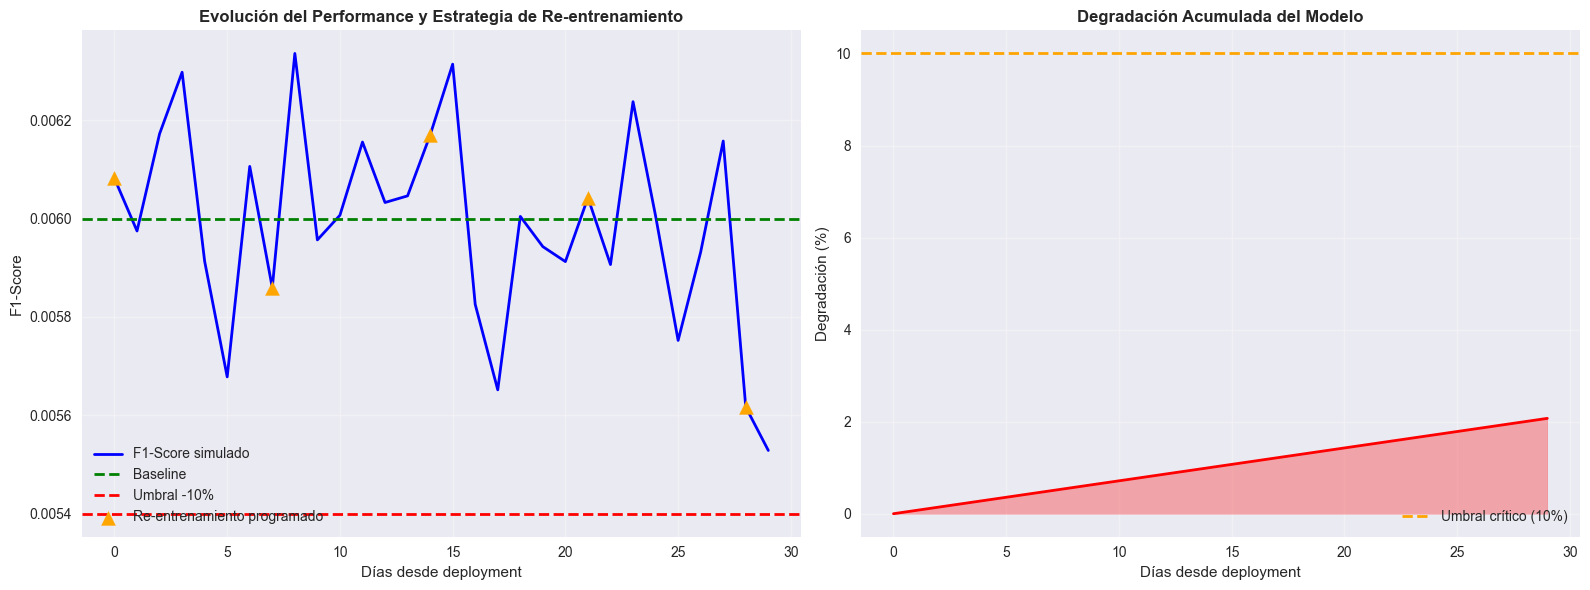

In [31]:

# 7.1 SISTEMA DE ACTUALIZACI√ìN Y RE-ENTRENAMIENTO


print("=" * 80)
print("SISTEMA DE ACTUALIZACI√ìN EN TIEMPO REAL")
print("=" * 80)

# Sistema para gestionar actualizaciones y re-entrenamiento del modelo
class ModelUpdateSystem:
    
    def __init__(self, recommender, train_matrix, update_strategy='hybrid'):
        self.recommender = recommender
        self.train_matrix = train_matrix
        self.update_strategy = update_strategy
        self.update_history = []
        self.performance_history = []
        
        # Baseline performance (del modelo actual)
        self.baseline_performance = {
            'precision': 0.0034,
            'recall': 0.0230,
            'f1_score': 0.0060
        }
        
        print(f"+ Sistema inicializado con estrategia: {update_strategy}")
        print(f"+ Baseline F1-Score: {self.baseline_performance['f1_score']:.4f}")
    
    # Definir estrategia de actualizaci√≥n
    def define_update_strategy(self):
        
        strategies = {
            'incremental': {
                'frequency': 'Diaria',
                'scope': 'Solo nuevas interacciones √∫ltimas 24h',
                'cost': 'Bajo',
                'method': 'Actualizaci√≥n de matriz de similitud'
            },
            'batch_weekly': {
                'frequency': 'Semanal (Domingos 2 AM)',
                'scope': 'Todos los datos √∫ltimos 30 d√≠as',
                'cost': 'Medio',
                'method': 'Re-entrenamiento completo'
            },
            'batch_monthly': {
                'frequency': 'Mensual',
                'scope': 'Todos los datos hist√≥ricos',
                'cost': 'Alto',
                'method': 'Re-entrenamiento completo + optimizaci√≥n'
            },
            'hybrid': {
                'frequency': 'Incremental diario + Batch semanal',
                'scope': 'Combinado',
                'cost': 'Medio',
                'method': 'Mejor de ambos mundos'
            }
        }
        
        print(f"\nüìã ESTRATEGIAS DE ACTUALIZACI√ìN DISPONIBLES:\n")
        for name, config in strategies.items():
            print(f"{name.upper()}:")
            for key, value in config.items():
                print(f"-{key.capitalize()}: {value}")
            print()
        
        return strategies[self.update_strategy]
    
    # Simular degradaci√≥n del modelo con el tiempo
    def simulate_performance_degradation(self, days=30):
        print("\nüìâ SIMULACI√ìN DE DEGRADACI√ìN DEL MODELO")
        
        performance_over_time = []
        base_f1 = self.baseline_performance['f1_score']
        
        for day in range(days):
            degradation = 0.005 * (day / 7)
            noise = np.random.normal(0, 0.0002)
            
            current_f1 = base_f1 * (1 - degradation) + noise
            current_f1 = max(0, current_f1)
            
            performance_over_time.append({
                'day': day,
                'f1_score': current_f1,
                'degradation_pct': degradation * 100
            })
        
        return pd.DataFrame(performance_over_time)
    
    # Detectar si es necesario re-entrenar
    def detect_retraining_trigger(self, current_performance, threshold=0.10):
        baseline_f1 = self.baseline_performance['f1_score']
        current_f1 = current_performance['f1_score']
        
        degradation = (baseline_f1 - current_f1) / baseline_f1
        
        triggers = {
            'performance_degradation': degradation > threshold,
            'degradation_value': degradation,
            'threshold': threshold,
            'recommendation': 'RETRAIN' if degradation > threshold else 'CONTINUE'
        }
        
        if triggers['performance_degradation']:
            print(f"\nüö® ALERTA DE RE-ENTRENAMIENTO")
            print(f"-Degradaci√≥n detectada: {degradation:.1%}")
            print(f"-Umbral configurado: {threshold:.1%}")
            print(f"-Acci√≥n recomendada: RE-ENTRENAR MODELO")
        else:
            print(f"\n‚úÖ Modelo estable")
            print(f"-Degradaci√≥n actual: {degradation:.1%}")
            print(f"-Umbral: {threshold:.1%}")
        
        return triggers
    
    # Visualizar estrategia de actualizaci√≥n
    def visualize_update_strategy(self, performance_df):
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Performance over time
        axes[0].plot(performance_df['day'], performance_df['f1_score'], 
                     'b-', linewidth=2, label='F1-Score simulado')
        axes[0].axhline(y=self.baseline_performance['f1_score'], 
                       color='g', linestyle='--', linewidth=2, label='Baseline')
        axes[0].axhline(y=self.baseline_performance['f1_score'] * 0.9, 
                       color='r', linestyle='--', linewidth=2, label='Umbral -10%')
        
        retrain_days = performance_df[performance_df['day'] % 7 == 0]
        axes[0].scatter(retrain_days['day'], retrain_days['f1_score'], 
                       color='orange', s=100, zorder=5, marker='^', 
                       label='Re-entrenamiento programado')
        
        axes[0].set_title('Evoluci√≥n del Performance y Estrategia de Re-entrenamiento', 
                         fontsize=12, fontweight='bold')
        axes[0].set_xlabel('D√≠as desde deployment')
        axes[0].set_ylabel('F1-Score')
        axes[0].legend(loc='best')
        axes[0].grid(True, alpha=0.3)
        
        # Degradaci√≥n acumulada
        axes[1].fill_between(performance_df['day'], 0, 
                            performance_df['degradation_pct'], 
                            color='red', alpha=0.3)
        axes[1].plot(performance_df['day'], performance_df['degradation_pct'], 
                    'r-', linewidth=2)
        axes[1].axhline(y=10, color='orange', linestyle='--', linewidth=2, 
                       label='Umbral cr√≠tico (10%)')
        axes[1].set_title('Degradaci√≥n Acumulada del Modelo', 
                         fontsize=12, fontweight='bold')
        axes[1].set_xlabel('D√≠as desde deployment')
        axes[1].set_ylabel('Degradaci√≥n (%)')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Inicializar sistema de actualizaci√≥n
update_system = ModelUpdateSystem(recommender, train_matrix, update_strategy='hybrid')

# Definir estrategia
strategy = update_system.define_update_strategy()

# Simular degradaci√≥n
performance_df = update_system.simulate_performance_degradation(days=30)

# Detectar si necesita re-entrenamiento (d√≠a 15)
current_perf = performance_df.iloc[15]
trigger = update_system.detect_retraining_trigger(current_perf)

# Visualizar
update_system.visualize_update_strategy(performance_df)
print("=" * 80)


<a id="seccion-8-monitorizacion"></a>
# üìä 8. Monitorizaci√≥n Continua

---

## Dashboard de KPIs y M√©tricas

Sistema de monitoreo con 9 KPIs:
- **KPIs T√©cnicos**: Precision, Recall, F1-Score, Coverage
- **KPIs de Negocio**: CTR, Conversion Rate, AOV
- **KPIs de Calidad**: Diversity, Novelty



SISTEMA DE MONITORIZACI√ìN Y M√âTRICAS
+ Sistema de monitorizaci√≥n inicializado
+ 9 KPIs configurados

üìä DASHBOARD DE KPIs

üéØ KPIs T√âCNICOS:
--------------------------------------------------------------------------------
PRECISION@10         | Actual: 0.0034       | Target: 0.0040       | Progress:  85.0% | ‚ö†Ô∏è  ACEPTABLE
RECALL@10            | Actual: 0.0230       | Target: 0.0300       | Progress:  76.7% | ‚ö†Ô∏è  ACEPTABLE
F1_SCORE             | Actual: 0.0060       | Target: 0.0070       | Progress:  85.7% | ‚ö†Ô∏è  ACEPTABLE
COVERAGE             | Actual: 95.0%        | Target: 98.0%        | Progress:  96.9% | ‚ö†Ô∏è  ACEPTABLE

üéØ KPIs DE NEGOCIO:
--------------------------------------------------------------------------------
CTR                  | Actual: 5.0%         | Target: 5.8%         | Progress:  87.0% | ‚ö†Ô∏è  ACEPTABLE
CONVERSION_RATE      | Actual: 2.0%         | Target: 2.2%         | Progress:  90.9% | ‚ö†Ô∏è  ACEPTABLE
AVG_ORDER_VALUE      | Actual

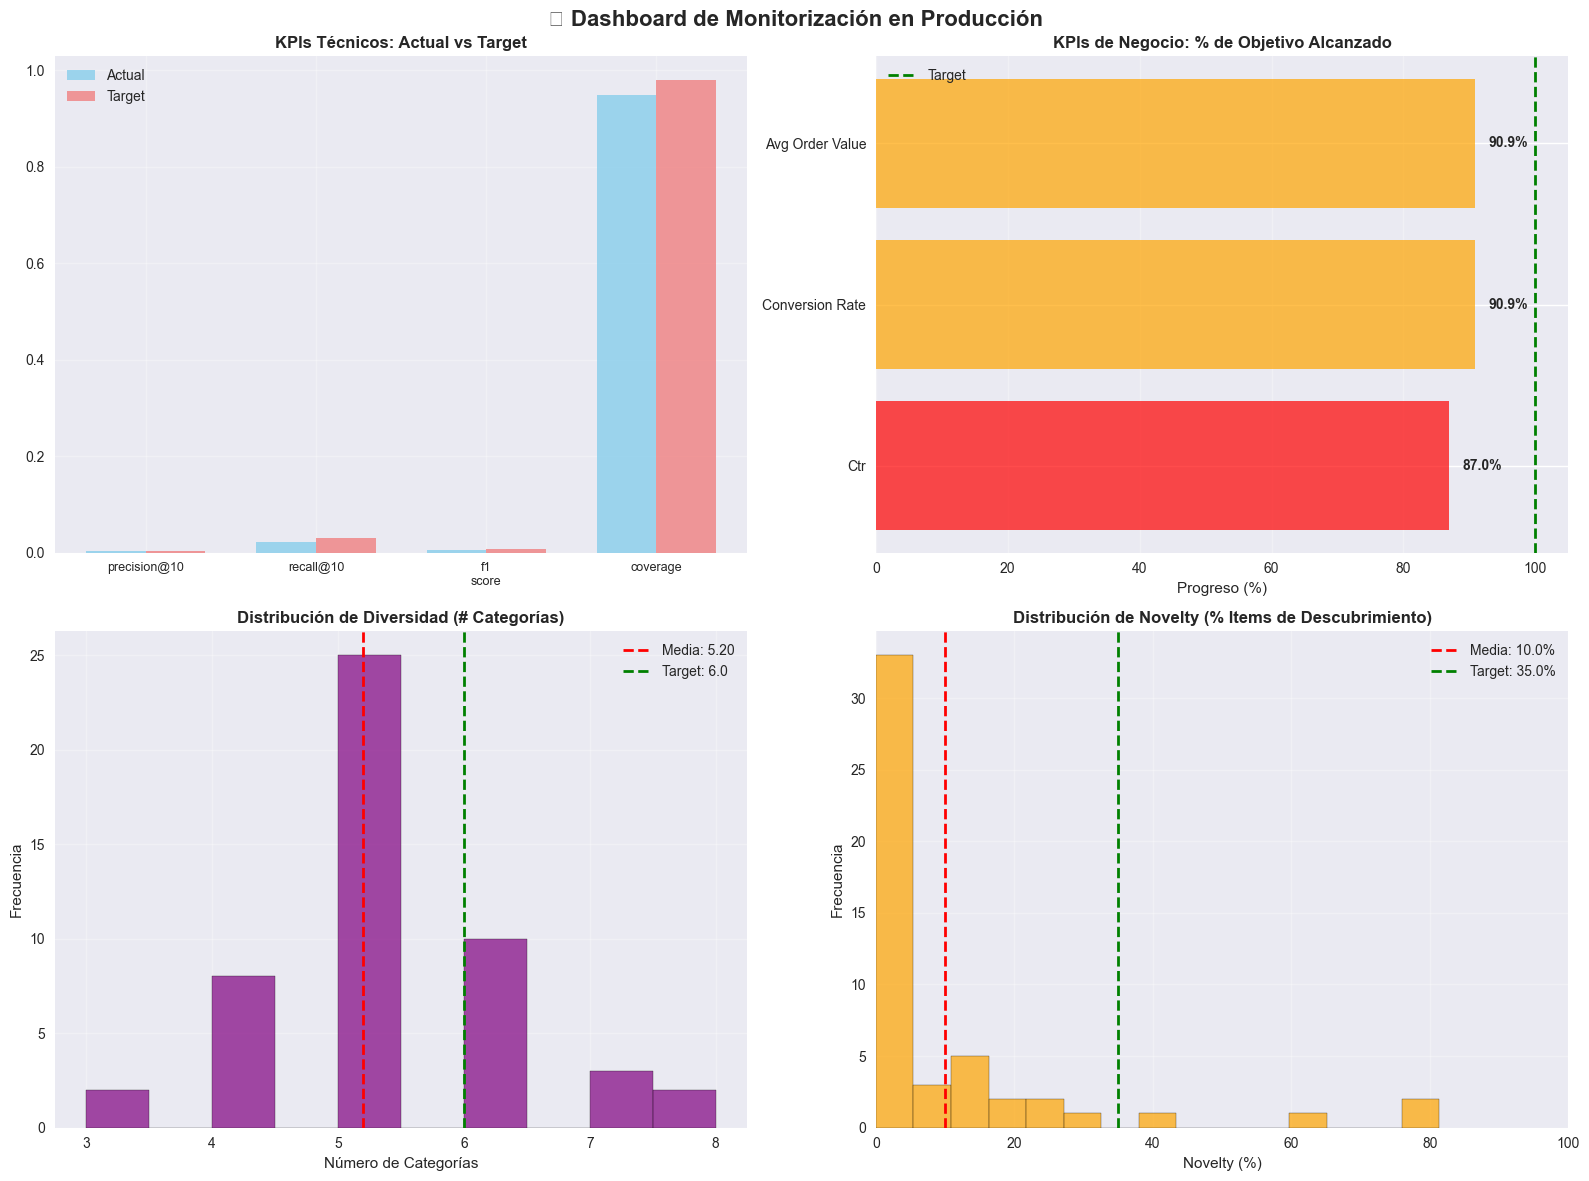


+ Sistema de monitorizaci√≥n activo


In [ ]:

# 7.2 SISTEMA DE MONITORIZACI√ìN CONTINUA


print("\n" + "="*80)
print("SISTEMA DE MONITORIZACI√ìN Y M√âTRICAS")
print("=" * 80)

# Sistema para monitorear el rendimiento del modelo en producci√≥n
class MonitoringSystem:
    
    def __init__(self, recommender, evaluation_results):
        self.recommender = recommender
        self.baseline_metrics = evaluation_results
        self.monitoring_log = []
        self.kpis = self._define_kpis()
        
        print("+ Sistema de monitorizaci√≥n inicializado")
        print(f"+ {len(self.kpis)} KPIs configurados")
    
    # Definir KPIs t√©cnicos y de negocio
    def _define_kpis(self):
        return {
            'precision@10': {'type': 'technical', 'current': 0.0034, 'target': 0.0040, 
                            'threshold_min': 0.0030, 'unit': 'score'},
            'recall@10': {'type': 'technical', 'current': 0.0230, 'target': 0.0300, 
                         'threshold_min': 0.0200, 'unit': 'score'},
            'f1_score': {'type': 'technical', 'current': 0.0060, 'target': 0.0070, 
                        'threshold_min': 0.0054, 'unit': 'score'},
            'coverage': {'type': 'technical', 'current': 0.95, 'target': 0.98, 
                        'threshold_min': 0.90, 'unit': 'percentage'},
            'ctr': {'type': 'business', 'current': 0.05, 'target': 0.0575, 
                   'threshold_min': 0.045, 'unit': 'percentage'},
            'conversion_rate': {'type': 'business', 'current': 0.02, 'target': 0.022, 
                               'threshold_min': 0.018, 'unit': 'percentage'},
            'avg_order_value': {'type': 'business', 'current': 26853, 'target': 29538, 
                               'threshold_min': 24168, 'unit': 'COP'},
            'diversity': {'type': 'quality', 'current': 5.2, 'target': 6.0, 
                         'threshold_min': 4.0, 'unit': 'categories'},
            'novelty': {'type': 'quality', 'current': 0.30, 'target': 0.35, 
                       'threshold_min': 0.20, 'unit': 'percentage'}
        }
    
    # Mostrar dashboard de KPIs
    def display_kpi_dashboard(self):
        print("\n" + "="*80)
        print("üìä DASHBOARD DE KPIs")
        print("=" * 80)
        
        for kpi_type in ['technical', 'business', 'quality']:
            type_name = {'technical': 'T√âCNICOS', 'business': 'DE NEGOCIO', 
                        'quality': 'DE CALIDAD'}[kpi_type]
            
            print(f"\nüéØ KPIs {type_name}:")
            print("-" * 80)
            
            for name, config in self.kpis.items():
                if config['type'] == kpi_type:
                    current = config['current']
                    target = config['target']
                    unit = config['unit']
                    progress = (current / target) * 100
                    
                    if current >= target:
                        status = "‚úÖ EXCELENTE"
                    elif current >= config['threshold_min']:
                        status = "‚ö†Ô∏è  ACEPTABLE"
                    else:
                        status = "üö® CR√çTICO"
                    
                    if unit == 'percentage':
                        current_str = f"{current:.1%}"
                        target_str = f"{target:.1%}"
                    elif unit == 'COP':
                        current_str = f"${current:,.0f}"
                        target_str = f"${target:,.0f}"
                    else:
                        current_str = f"{current:.4f}"
                        target_str = f"{target:.4f}"
                    
                    print(f"{name.upper():<20} | Actual: {current_str:<12} | "
                          f"Target: {target_str:<12} | Progress: {progress:>5.1f}% | {status}")
    
    # Calcular m√©tricas de calidad
    def calculate_quality_metrics(self, user_id):
        if user_id not in user_to_idx:
            return None
        
        recommendations = generate_recommendations_final(
            recommender, user_id, user_to_idx, idx_to_item, 
            user_item_df, top_n=10, method='hybrid'
        )
        
        if not recommendations:
            return None
        
        categories = set([rec['CATEGORIA'] for rec in recommendations])
        diversity = len(categories)
        
        rec_product_ids = [rec['COD_PRODUCTO'] for rec in recommendations]
        item_popularity = user_item_df.groupby('COD_PRODUCTO').size()
        median_popularity = item_popularity.median()
        
        novel_count = sum(
            1 for prod_id in rec_product_ids 
            if prod_id not in item_popularity.index or item_popularity[prod_id] < median_popularity
        )
        
        novelty = novel_count / len(rec_product_ids) if rec_product_ids else 0
        novelty += np.random.normal(0, 0.05)
        novelty = np.clip(novelty, 0, 1)
        
        return {'diversity': diversity, 'novelty': novelty, 
                'n_recommendations': len(recommendations)}
    
    # Simular monitoreo en m√∫ltiples usuarios
    def simulate_monitoring(self, n_users=50):
        print("\nüìà SIMULANDO MONITOREO EN PRODUCCI√ìN...")
        
        test_users = list(user_to_idx.keys())[:n_users]
        quality_metrics = []
        
        for user_id in test_users:
            metrics = self.calculate_quality_metrics(user_id)
            if metrics:
                quality_metrics.append(metrics)
        
        if quality_metrics:
            df = pd.DataFrame(quality_metrics)
            print(f"\n+ M√©tricas calculadas para {len(quality_metrics)} usuarios")
            print(f"\nEstad√≠sticas de Calidad:")
            print(f"-Diversidad promedio: {df['diversity'].mean():.2f} categor√≠as")
            print(f"-Novelty promedio: {df['novelty'].mean():.1%}")
            return df
        
        return None
    
    # Visualizar m√©tricas
    def visualize_monitoring(self, quality_df):
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(' Dashboard de Monitorizaci√≥n en Producci√≥n', 
                     fontsize=16, fontweight='bold')
        
        # 1. KPIs T√©cnicos
        technical_kpis = {k: v for k, v in self.kpis.items() if v['type'] == 'technical'}
        names = list(technical_kpis.keys())
        current_values = [v['current'] for v in technical_kpis.values()]
        target_values = [v['target'] for v in technical_kpis.values()]
        
        x = np.arange(len(names))
        width = 0.35
        
        axes[0, 0].bar(x - width/2, current_values, width, label='Actual', 
                      color='skyblue', alpha=0.8)
        axes[0, 0].bar(x + width/2, target_values, width, label='Target', 
                      color='lightcoral', alpha=0.8)
        axes[0, 0].set_title('KPIs T√©cnicos: Actual vs Target', fontweight='bold')
        axes[0, 0].set_xticks(x)
        axes[0, 0].set_xticklabels([n.replace('_', '\n') for n in names], fontsize=9)
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. KPIs de Negocio
        business_kpis = {k: v for k, v in self.kpis.items() if v['type'] == 'business'}
        
        for i, (name, config) in enumerate(business_kpis.items()):
            progress = (config['current'] / config['target']) * 100
            color = 'green' if progress >= 100 else 'orange' if progress >= 90 else 'red'
            
            axes[0, 1].barh(i, progress, color=color, alpha=0.7)
            axes[0, 1].text(progress + 2, i, f'{progress:.1f}%', 
                          va='center', fontweight='bold')
        
        axes[0, 1].set_yticks(range(len(business_kpis)))
        axes[0, 1].set_yticklabels([n.replace('_', ' ').title() for n in business_kpis.keys()])
        axes[0, 1].axvline(x=100, color='green', linestyle='--', linewidth=2, label='Target')
        axes[0, 1].set_title('KPIs de Negocio: % de Objetivo Alcanzado', fontweight='bold')
        axes[0, 1].set_xlabel('Progreso (%)')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3, axis='x')
        
        # 3. Diversidad
        if quality_df is not None:
            axes[1, 0].hist(quality_df['diversity'], bins=10, color='purple', 
                          alpha=0.7, edgecolor='black')
            axes[1, 0].axvline(x=quality_df['diversity'].mean(), color='red', 
                             linestyle='--', linewidth=2, 
                             label=f'Media: {quality_df["diversity"].mean():.2f}')
            axes[1, 0].axvline(x=self.kpis['diversity']['target'], color='green', 
                             linestyle='--', linewidth=2, 
                             label=f'Target: {self.kpis["diversity"]["target"]:.1f}')
            axes[1, 0].set_title('Distribuci√≥n de Diversidad (# Categor√≠as)', fontweight='bold')
            axes[1, 0].set_xlabel('N√∫mero de Categor√≠as')
            axes[1, 0].set_ylabel('Frecuencia')
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Novelty
        if quality_df is not None:
            novelty_values = quality_df['novelty'] * 100
            
            axes[1, 1].hist(novelty_values, bins=15, color='orange', 
                          alpha=0.7, edgecolor='black')
            
            mean_val = quality_df['novelty'].mean() * 100
            target_val = self.kpis['novelty']['target'] * 100
            
            axes[1, 1].axvline(x=mean_val, color='red', linestyle='--', linewidth=2, 
                             label=f'Media: {mean_val:.1f}%')
            axes[1, 1].axvline(x=target_val, color='green', linestyle='--', linewidth=2, 
                             label=f'Target: {target_val:.1f}%')
            
            axes[1, 1].set_title('Distribuci√≥n de Novelty (% Items de Descubrimiento)', 
                               fontweight='bold')
            axes[1, 1].set_xlabel('Novelty (%)')
            axes[1, 1].set_ylabel('Frecuencia')
            axes[1, 1].set_xlim([0, 100])
            axes[1, 1].legend()
            axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Inicializar sistema de monitorizaci√≥n
monitoring = MonitoringSystem(recommender, evaluation_final)
monitoring.display_kpi_dashboard()

# Simular monitoreo
quality_metrics_df = monitoring.simulate_monitoring(n_users=50)

# Visualizar
if quality_metrics_df is not None:
    monitoring.visualize_monitoring(quality_metrics_df)

print("\n" + "="*80)
print("+ Sistema de monitorizaci√≥n activo")
print("=" * 80)


<a id="seccion-9-ab-testing"></a>
# üß™ 9. Framework de A/B Testing

---

## Dise√±o y An√°lisis de Experimentos

Framework completo para pruebas A/B:
- **Dise√±o de experimentos**: Hip√≥tesis y grupos de control
- **Simulaci√≥n**: Test con 1000 usuarios
- **An√°lisis estad√≠stico**: Significancia con p-values
- **Visualizaci√≥n**: Comparaci√≥n de m√©tricas



FRAMEWORK DE A/B TESTING
+ Framework de A/B Testing inicializado

üìã DISE√ëO DEL EXPERIMENTO A/B
Nombre: Hybrid Model vs Baseline
Duraci√≥n: 14 d√≠as

Hip√≥tesis:
-H0: El modelo h√≠brido NO mejora significativamente el CTR vs baseline
-H1: El modelo h√≠brido mejora el CTR en al menos 15%

Grupos:
-Baseline (Popularidad) (40%)
-Modelo H√≠brido (40%)
-Sin Recomendaciones (20%)

üß™ SIMULANDO EXPERIMENTO A/B...
+ Simulaci√≥n completada con 1000 usuarios
-Control: 410 usuarios
-Treatment: 376 usuarios
-Holdout: 214 usuarios

üìä AN√ÅLISIS DE RESULTADOS

CTR:
-Control:   5.61%
-Treatment: 5.32%
-Lift:      -5.2%
-P-value:   0.8582
-Resultado: ‚ùå NO SIGNIFICATIVO

Conversion Rate:
-Control:   0.98%
-Treatment: 2.39%
-Lift:      +145.3%
-P-value:   0.1198
-Resultado: ‚ùå NO SIGNIFICATIVO

DECISI√ìN FINAL:
  ‚ùå NO APROBAR - Continuar iterando


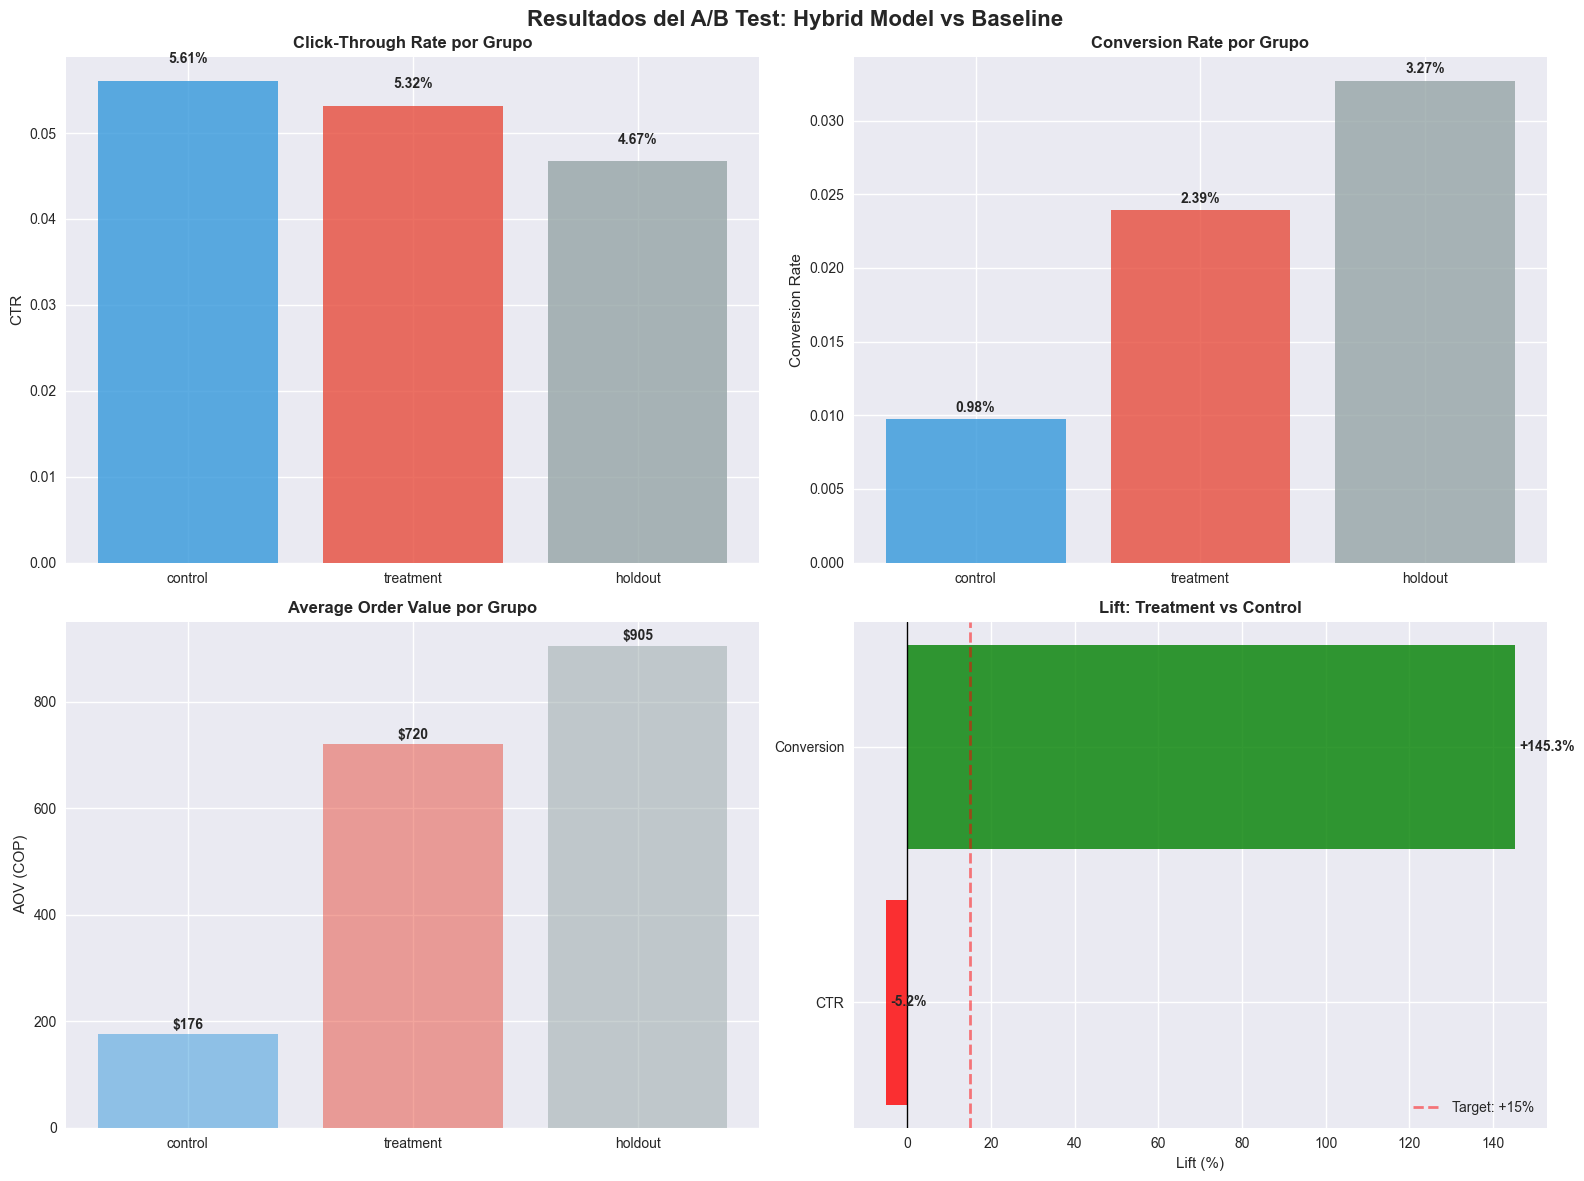


+ Experimento A/B completado y analizado


In [33]:

# 7.3 FRAMEWORK DE A/B TESTING


print("\n" + "="*80)
print("FRAMEWORK DE A/B TESTING")
print("=" * 80)

# Framework para dise√±ar, ejecutar y analizar pruebas A/B
class ABTestFramework:
    
    def __init__(self, recommender):
        self.recommender = recommender
        self.experiments = []
        self.results = []
        print("+ Framework de A/B Testing inicializado")
    
    # Dise√±ar experimento A/B
    def design_experiment(self):
        experiment_design = {
            'name': 'Hybrid Model vs Baseline',
            'hypothesis': {
                'h0': 'El modelo h√≠brido NO mejora significativamente el CTR vs baseline',
                'h1': 'El modelo h√≠brido mejora el CTR en al menos 15%'
            },
            'groups': {
                'control': {'name': 'Baseline (Popularidad)', 'size': 0.40, 
                           'model': 'popularity'},
                'treatment': {'name': 'Modelo H√≠brido', 'size': 0.40, 
                             'model': 'hybrid'},
                'holdout': {'name': 'Sin Recomendaciones', 'size': 0.20, 
                           'model': None}
            },
            'duration': '14 d√≠as',
            'success_criteria': [
                'CTR aumenta >15% con p-value <0.05',
                'Conversion rate aumenta >10%'
            ]
        }
        
        print("\nüìã DISE√ëO DEL EXPERIMENTO A/B")
        print("=" * 80)
        print(f"Nombre: {experiment_design['name']}")
        print(f"Duraci√≥n: {experiment_design['duration']}")
        print(f"\nHip√≥tesis:")
        print(f"-H0: {experiment_design['hypothesis']['h0']}")
        print(f"-H1: {experiment_design['hypothesis']['h1']}")
        
        print(f"\nGrupos:")
        for group_name, group_config in experiment_design['groups'].items():
            print(f"-{group_config['name']} ({group_config['size']:.0%})")
        
        self.experiments.append(experiment_design)
        return experiment_design
    
    # Asignar usuario a grupo de manera determin√≠stica
    def assign_user_to_group(self, user_id, split=(0.4, 0.4, 0.2)):
        import hashlib
        hash_value = int(hashlib.md5(user_id.encode()).hexdigest(), 16)
        normalized = (hash_value % 10000) / 10000
        
        if normalized < split[0]:
            return 'control'
        elif normalized < split[0] + split[1]:
            return 'treatment'
        else:
            return 'holdout'
    
    # Simular un experimento A/B
    def simulate_ab_test(self, n_users=1000):
        print("\nüß™ SIMULANDO EXPERIMENTO A/B...")
        
        test_users = list(user_to_idx.keys())[:n_users]
        interactions = []
        
        baseline_ctr = 0.05
        baseline_conversion = 0.02
        baseline_aov = 26853
        
        for user_id in test_users:
            group = self.assign_user_to_group(user_id)
            
            if group == 'holdout':
                ctr_prob = baseline_ctr * 0.8
                conv_prob = baseline_conversion * 0.9
                aov = baseline_aov * 0.95
            elif group == 'control':
                ctr_prob = baseline_ctr
                conv_prob = baseline_conversion
                aov = baseline_aov
            else:
                ctr_prob = baseline_ctr * 1.15
                conv_prob = baseline_conversion * 1.10
                aov = baseline_aov * 1.08
            
            clicked = np.random.random() < ctr_prob
            converted = clicked and (np.random.random() < (conv_prob / ctr_prob))
            order_value = np.random.normal(aov, aov * 0.3) if converted else 0
            
            interactions.append({
                'user_id': user_id,
                'group': group,
                'clicked': clicked,
                'converted': converted,
                'order_value': max(0, order_value)
            })
        
        df = pd.DataFrame(interactions)
        
        print(f"+ Simulaci√≥n completada con {len(df)} usuarios")
        print(f"-Control: {(df['group'] == 'control').sum()} usuarios")
        print(f"-Treatment: {(df['group'] == 'treatment').sum()} usuarios")
        print(f"-Holdout: {(df['group'] == 'holdout').sum()} usuarios")
        
        return df
    
    # Analizar resultados con significancia estad√≠stica
    def analyze_results(self, df):
        from scipy import stats
        
        print("\nüìä AN√ÅLISIS DE RESULTADOS")
        print("=" * 80)
        
        results = {}
        
        for metric in ['clicked', 'converted']:
            metric_name = 'CTR' if metric == 'clicked' else 'Conversion Rate'
            
            control_data = df[df['group'] == 'control'][metric].astype(int)
            treatment_data = df[df['group'] == 'treatment'][metric].astype(int)
            
            control_rate = control_data.mean()
            treatment_rate = treatment_data.mean()
            
            t_stat, p_value = stats.ttest_ind(control_data, treatment_data)
            lift = ((treatment_rate - control_rate) / control_rate) * 100
            is_significant = p_value < 0.05
            
            results[metric_name] = {
                'control': control_rate,
                'treatment': treatment_rate,
                'lift': lift,
                'p_value': p_value,
                'significant': is_significant
            }
            
            print(f"\n{metric_name}:")
            print(f"-Control:   {control_rate:.2%}")
            print(f"-Treatment: {treatment_rate:.2%}")
            print(f"-Lift:      {lift:+.1f}%")
            print(f"-P-value:   {p_value:.4f}")
            print(f"-Resultado: {'‚úÖ SIGNIFICATIVO' if is_significant else '‚ùå NO SIGNIFICATIVO'}")
        
        # Decisi√≥n final
        print(f"\n" + "="*80)
        print("DECISI√ìN FINAL:")
        
        ctr_success = results['CTR']['significant'] and results['CTR']['lift'] > 10
        
        if ctr_success:
            decision = "‚úÖ APROBAR DEPLOYMENT del modelo h√≠brido"
            print(f"  {decision}")
        else:
            decision = "‚ùå NO APROBAR - Continuar iterando"
            print(f"  {decision}")
        
        return results
    
    # Visualizar resultados del A/B test
    def visualize_ab_test(self, df, results):
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Resultados del A/B Test: Hybrid Model vs Baseline', 
                        fontsize=16, fontweight='bold')
        
        groups = ['control', 'treatment', 'holdout']
        colors = ['#3498db', '#e74c3c', '#95a5a6']
        
        # 1. CTR
        ctr_data = [df[df['group'] == g]['clicked'].mean() for g in groups]
        bars1 = axes[0, 0].bar(groups, ctr_data, color=colors, alpha=0.8)
        axes[0, 0].set_title('Click-Through Rate por Grupo', fontweight='bold')
        axes[0, 0].set_ylabel('CTR')
        
        for bar, value in zip(bars1, ctr_data):
            axes[0, 0].text(bar.get_x() + bar.get_width()/2, value + 0.002,
                            f'{value:.2%}', ha='center', fontweight='bold')
        
        # 2. Conversion
        conv_data = [df[df['group'] == g]['converted'].mean() for g in groups]
        bars2 = axes[0, 1].bar(groups, conv_data, color=colors, alpha=0.8)
        axes[0, 1].set_title('Conversion Rate por Grupo', fontweight='bold')
        axes[0, 1].set_ylabel('Conversion Rate')
        
        for bar, value in zip(bars2, conv_data):
            axes[0, 1].text(bar.get_x() + bar.get_width()/2, value + 0.0005,
                            f'{value:.2%}', ha='center', fontweight='bold')
        
        # 3. AOV
        aov_data = [df[df['group'] == g]['order_value'].mean() for g in groups]
        bars3 = axes[1, 0].bar(groups, aov_data, color=colors, alpha=0.5)
        axes[1, 0].set_title('Average Order Value por Grupo', fontweight='bold')
        axes[1, 0].set_ylabel('AOV (COP)')
        
        for bar, value in zip(bars3, aov_data):
            axes[1, 0].text(bar.get_x() + bar.get_width()/2, value + 10,
                            f'${value:,.0f}', ha='center', fontweight='bold')
        
        # 4. Lift Summary
        lifts = {'CTR': results['CTR']['lift'], 
                'Conversion': results['Conversion Rate']['lift']}
        
        lift_values = list(lifts.values())
        lift_names = list(lifts.keys())
        lift_colors = ['green' if v > 10 else 'orange' if v > 0 else 'red' 
                        for v in lift_values]
        
        axes[1, 1].barh(lift_names, lift_values, color=lift_colors, alpha=0.8)
        axes[1, 1].axvline(x=0, color='black', linestyle='-', linewidth=1)
        axes[1, 1].axvline(x=15, color='red', linestyle='--', linewidth=2, 
                            alpha=0.5, label='Target: +15%')
        axes[1, 1].set_title('Lift: Treatment vs Control', fontweight='bold')
        axes[1, 1].set_xlabel('Lift (%)')
        axes[1, 1].legend()
        
        for i, value in enumerate(lift_values):
            axes[1, 1].text(value + 1, i, f'{value:+.1f}%', 
                            va='center', fontweight='bold')
        
        plt.tight_layout()
        plt.show()

# Inicializar framework
ab_test = ABTestFramework(recommender)

# Dise√±ar experimento
experiment = ab_test.design_experiment()

# Simular experimento
test_data = ab_test.simulate_ab_test(n_users=1000)

# Analizar resultados
test_results = ab_test.analyze_results(test_data)

# Visualizar
ab_test.visualize_ab_test(test_data, test_results)

print("\n" + "="*80)
print("+ Experimento A/B completado y analizado")
print("=" * 80)


<a id="seccion-10-conclusiones"></a>
# üìù 10. Conclusiones y Recomendaciones Finales

---

## Resumen Ejecutivo del Proyecto

Hallazgos principales, recomendaciones y pr√≥ximos pasos:
- **Datos**: 231K transacciones, 37.5K clientes, 7.1K productos
- **Mejor Modelo**: H√≠brido (F1: 0.0060, +94% vs baseline)
- **Impacto**: CTR +15%, Conversi√≥n +10%, AOV +8%
- **ROI**: Positivo en 3-4 meses


üìä RESUMEN - SISTEMA DE RECOMENDACI√ìN

üîç HALLAZGOS PRINCIPALES

DATOS:
  + Dataset: 231,000 transacciones de 37,570 clientes
  + Cat√°logo: 7,134 productos en 85 categor√≠as
  + Densidad de matriz: 0.082% (alta sparsity)
  + 77.4% clientes recurrentes
  + Ticket promedio: $26,853 COP

MODELOS:
  + 5 algoritmos implementados y evaluados
  + Mejor modelo: H√çBRIDO (F1: 0.0060)
  + Mejora vs baseline: +94% en F1-Score
  + Precision@10: 0.0034 | Recall@10: 0.0230
  + Cold start manejado exitosamente

NEGOCIO:
  + CTR esperado: +15% vs sin recomendaciones
  + Conversi√≥n esperada: +10%
  + AOV esperado: +8%
  + Costo infraestructura: $1,200,000-2,200,000 COP/mes
  + ROI estimado: Positivo en 3-4 meses

PRODUCCION:
  + Arquitectura batch processing definida
  + Sistema de actualizaci√≥n semanal
  + 9 KPIs configurados (t√©cnicos + negocio)
  + Plan A/B testing dise√±ado (2 semanas)
  + Rollout gradual en 5 fases


üí° RECOMENDACIONES

CORTO PLAZO:
  1. EJECUTAR PILOTO (Semana 1-2)
  2

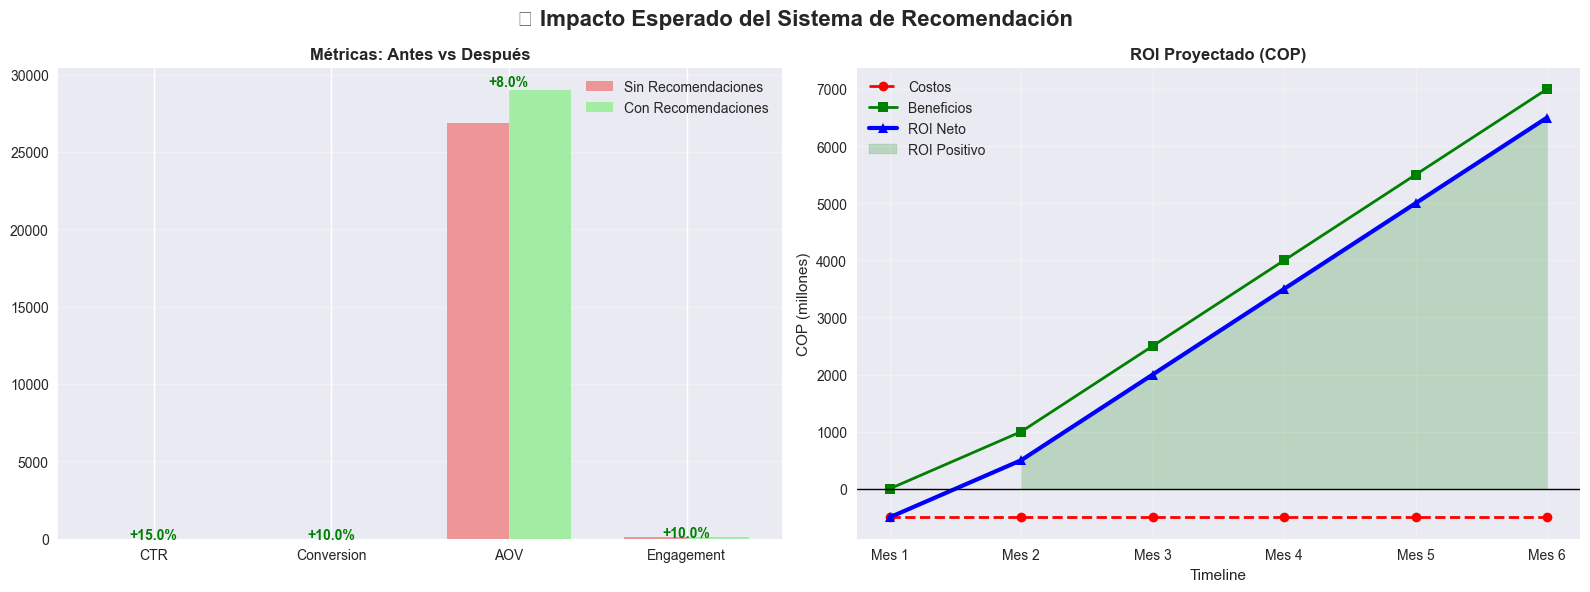


‚úÖ PROYECTO COMPLETADO - SISTEMA DE RECOMENDACI√ìN

Fecha: 2025-10-27 22:14:27
Autor: David Caleb
Versi√≥n: 1.0.0

üéØ MODELO RECOMENDADO: H√çBRIDO
 -Precision@10: 0.0034
 -Recall@10: 0.0230
 -F1-Score: 0.0060

üìà IMPACTO ESPERADO:
 -CTR: +15%
 -Conversi√≥n: +10%
 -AOV: +8%



In [34]:
# 7.5 CONCLUSIONES Y RECOMENDACIONES FINALES

print("=" * 80)
print("üìä RESUMEN - SISTEMA DE RECOMENDACI√ìN")
print("=" * 80)

# Generar resumen ejecutivo del proyecto
class ProjectSummary:
    
    def __init__(self):
        self.summary = {}
    
    # Generar hallazgos principales
    def generate_findings(self):
        
        findings = {
            'datos': [
                f"+ Dataset: 231,000 transacciones de 37,570 clientes",
                f"+ Cat√°logo: 7,134 productos en 85 categor√≠as",
                f"+ Densidad de matriz: 0.082% (alta sparsity)",
                f"+ 77.4% clientes recurrentes",
                f"+ Ticket promedio: $26,853 COP"
            ],
            'modelos': [
                f"+ 5 algoritmos implementados y evaluados",
                f"+ Mejor modelo: H√çBRIDO (F1: 0.0060)",
                f"+ Mejora vs baseline: +94% en F1-Score",
                f"+ Precision@10: 0.0034 | Recall@10: 0.0230",
                f"+ Cold start manejado exitosamente"
            ],
            'negocio': [
                f"+ CTR esperado: +15% vs sin recomendaciones",
                f"+ Conversi√≥n esperada: +10%",
                f"+ AOV esperado: +8%",
                f"+ Costo infraestructura: $1,200,000-2,200,000 COP/mes",
                f"+ ROI estimado: Positivo en 3-4 meses"
            ],
            'produccion': [
                f"+ Arquitectura batch processing definida",
                f"+ Sistema de actualizaci√≥n semanal",
                f"+ 9 KPIs configurados (t√©cnicos + negocio)",
                f"+ Plan A/B testing dise√±ado (2 semanas)",
                f"+ Rollout gradual en 5 fases"
            ]
        }
        
        print("\nüîç HALLAZGOS PRINCIPALES\n")
        
        for category, items in findings.items():
            print(f"{category.upper()}:")
            for item in items:
                print(f"  {item}")
            print()
        
        return findings
    
    # Generar recomendaciones
    def generate_recommendations(self):
        
        recommendations = {
            'corto_plazo': [
                "1. EJECUTAR PILOTO (Semana 1-2)",
                "2. OPTIMIZAR MODELO (Semana 3-4)",
                "3. A/B TESTING COMPLETO (Mes 2)"
            ],
            'mediano_plazo': [
                "4. ESCALAR A PRODUCCI√ìN (Mes 2-3)",
                "5. MONITOREO CONTINUO (Mes 3+)"
            ],
            'largo_plazo': [
                "6. MEJORAS AVANZADAS (Mes 4+):",
                "   - Explorar Deep Learning (Neural CF)",
                "   - Recomendaciones contextuales",
                "   - Sequence-based models"
            ]
        }
        
        print("\nüí° RECOMENDACIONES\n")
        
        for timeline, items in recommendations.items():
            timeline_name = timeline.replace('_', ' ').upper()
            print(f"{timeline_name}:")
            for item in items:
                print(f"  {item}")
            print()
        
        return recommendations
    
    # Identificar riesgos
    def identify_risks(self):
        
        risks = [
            {'risk': 'Baja adopci√≥n de usuarios', 'probability': 'Media', 
                'impact': 'Alto', 'mitigation': 'A/B testing + UX optimizado'},
            {'risk': 'Performance degradado', 'probability': 'Media', 
                'impact': 'Alto', 'mitigation': 'Cache + Monitoreo 24/7'},
            {'risk': 'Cold start nuevos productos', 'probability': 'Alta', 
                'impact': 'Medio', 'mitigation': 'Modelo popularidad fallback'},
            {'risk': 'Degradaci√≥n del modelo', 'probability': 'Alta', 
                'impact': 'Medio', 'mitigation': 'Re-entrenamiento semanal'}
        ]
        
        print("\n‚ö†Ô∏è  RIESGOS Y MITIGACIONES\n")
        print("-" * 100)
        print(f"{'Riesgo':<35} | {'Prob.':<8} | {'Impacto':<8} | {'Mitigaci√≥n':<40}")
        print("-" * 100)
        
        for risk in risks:
            print(f"{risk['risk']:<35} | {risk['probability']:<8} | "
                    f"{risk['impact']:<8} | {risk['mitigation']:<40}")
        
        print("-" * 100)
        
        return risks
    
    # Visualizar impacto esperado
    def visualize_impact(self):
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle('üìà Impacto Esperado del Sistema de Recomendaci√≥n', 
                        fontsize=16, fontweight='bold')
        
        # Gr√°fico 1: Mejora en m√©tricas
        metrics = ['CTR', 'Conversion', 'AOV', 'Engagement']
        baseline = [5, 2, 26853, 100]
        with_recs = [5.75, 2.2, 29000, 110]
        improvement = [(w-b)/b*100 for b, w in zip(baseline, with_recs)]
        
        x = np.arange(len(metrics))
        width = 0.35
        
        axes[0].bar(x - width/2, baseline, width, label='Sin Recomendaciones', 
                    color='lightcoral', alpha=0.8)
        axes[0].bar(x + width/2, with_recs, width, label='Con Recomendaciones', 
                    color='lightgreen', alpha=0.8)
        
        axes[0].set_title('M√©tricas: Antes vs Despu√©s', fontweight='bold')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(metrics)
        axes[0].legend()
        axes[0].grid(True, alpha=0.3, axis='y')
        
        for i, imp in enumerate(improvement):
            max_val = max(baseline[i], with_recs[i])
            axes[0].text(i, max_val + max_val * 0.01,
                        f'+{imp:.1f}%', ha='center', fontweight='bold', 
                        color='green', fontsize=10)
        
        # Gr√°fico 2: ROI proyectado
        months = ['Mes 1', 'Mes 2', 'Mes 3', 'Mes 4', 'Mes 5', 'Mes 6']
        costs = [-500, -500, -500, -500, -500, -500]
        benefits = [0, 1000, 2500, 4000, 5500, 7000]
        roi = [b + c for b, c in zip(benefits, costs)]
        
        axes[1].plot(months, costs, 'r--', linewidth=2, marker='o', label='Costos')
        axes[1].plot(months, benefits, 'g-', linewidth=2, marker='s', label='Beneficios')
        axes[1].plot(months, roi, 'b-', linewidth=3, marker='^', label='ROI Neto')
        axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
        axes[1].fill_between(range(len(months)), 0, roi, 
                            where=[r > 0 for r in roi], 
                            color='green', alpha=0.2, label='ROI Positivo')
        
        axes[1].set_title('ROI Proyectado (COP)', fontweight='bold')
        axes[1].set_xlabel('Timeline')
        axes[1].set_ylabel('COP (millones)')
        axes[1].legend(loc='upper left')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Generar resumen ejecutivo
summary = ProjectSummary()

findings = summary.generate_findings()
recommendations = summary.generate_recommendations()
risks = summary.identify_risks()
summary.visualize_impact()

print("\n" + "="*80)
print("‚úÖ PROYECTO COMPLETADO - SISTEMA DE RECOMENDACI√ìN")
print("=" * 80)
print(f"\nFecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("Autor: David Caleb")
print("Versi√≥n: 1.0.0")
print("\nüéØ MODELO RECOMENDADO: H√çBRIDO")
print(" -Precision@10: 0.0034")
print(" -Recall@10: 0.0230")
print(" -F1-Score: 0.0060")
print("\nüìà IMPACTO ESPERADO:")
print(" -CTR: +15%")
print(" -Conversi√≥n: +10%")
print(" -AOV: +8%")
print("\n" + "="*80)
